In [1]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
import yfinance as yf
from datetime import datetime
from typing import TypedDict
import time
import re
import matplotlib.pyplot as plt
import ta

/home/lang-chain/miniconda3/envs/Agentic_AI_MCP_RAG_Chat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# workflow simple design
[Trigger]</br>
     ↓</br>
[Discovery Layer] </br>
     ↓ </br>
[Pre-Filter Layer] </br>
     ↓ </br>
[Deep Analysis Layer] </br>
     ↓ </br>
[Risk Management Layer]  </br>
     ↓ </br>
[Portfolio Agent] </br>
     ↓ </br>
BUY? (with confidence score) </br>
     ↓ </br>
[Alert Agent] </br>
     ↓ </br>
⏸ WAIT FOR HUMAN (with timeout) </br>
     ↓ </br>
YES ──→ [Execution Engine] → [Broker] </br>
NO  ──→ [Log & End] → [Feedback to Discovery] </br>
     ↓ </br>
[Memory Agent] ← Store execution data </br>
     ↓ </br>
[Performance Analytics] ← New component </br>
     ↓ </br>
[Confirmation Agent] </br>
     ↓ </br>
[Final Report Agent] </br>

In [2]:
search_tool = TavilySearch(max_results = 5)

config

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import os,threading
from twilio.rest import Client
TWILIO_ACCOUNT_SID  = os.getenv("TWILIO_ACCOUNT_SID")
TWILIO_AUTH_TOKEN   = os.getenv("TWILIO_AUTH_TOKEN")
TWILIO_WHATSAPP_NUM = os.getenv("TWILIO_WHATSAPP_NUM")   
YOUR_WHATSAPP_NUM   = os.getenv("YOUR_WHATSAPP_NUM")
MEMORY_FILE         = "memory.json"

REPORTS_DIR         = "reports"
CHARTS_DIR          = "charts"

APPROVAL_TIMEOUT    = 300                        # 5 minutes

model  = ChatGroq(model="llama-3.1-8b-instant", temperature=0.3, max_tokens=1000)
client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)


approval_results = {}          # {ticker: True/False}
pending_tickers  = set()
all_done_event   = threading.Event()


In [5]:
approval_results = {}
pending_tickers  = set()
all_done_event   = threading.Event()

In [6]:
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR,  exist_ok=True)

Layer 1 -- [Trigger]

In [7]:
class StockState(TypedDict):
    trigger_type: str
    trigger_source: str
    trigger_time: str
    query: str

    search_result: list
    tickers: list
    filtered_stocks:   list
    rejected_stocks:   list

    sentiment_data:    dict    
    technical_data:    dict    
    fundamental_data:  dict    
    analysis_scores:   dict 

    risk_data:         dict    
    risk_approved:     list    
    risk_rejected:     list   
    analysis_scores:   dict



    recommendations:   list 
    human_decisions:   dict
    alert_message_sids:list
    executed_trades:   list
    rejected_trades:   list
    memory_saved:      bool

    performance_metrics: dict
    chart_paths:         list
    confirmation_sent:   bool
    report_path:         str
    report_summary:      str

    


Trigger for firing agentic search and for buy and sale

schedule trigger

In [8]:
def scheduled_trigger(state:StockState):
    now = datetime.now()
    hour = now.hour
    if 9 <=hour <11:
        session="market open"
        query = "Top gaining stocks at market open today US"
    elif 11 <=hour<14:
        session = "mid day"
        query = "Top momentum stocks midday trading US market"
    elif 14<=hour <16:
        session = 'pre close'
        query = "Top stocls gaining volume per-market close US"
    else:
        session = "after-hurs"
        query   = "After hours top gaining stocks US market today"
    
    print(f" Scheduled Trigger fired - session: {session}")
    return{
        "trigger_type": "scheduled",
        "trigger_source": f"corn job - {session} session",
        "trigger_time": now.strftime("%Y-%m-%d %H:%M:%S"),
        "query": query
    }

manual trigger

In [9]:
def manual_trigger(query:str) -> dict:
    "for manual query and use  when user want specific search"
    print(f" manual trigger fired - query: '{query}'")
    return{
        "trigger_type": "manual",
        "trigger_source": "user input",
        "trigger_time" : datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "query": query
    }

price alert trigger

In [10]:
import yfinance as yf
import pandas as pd
all_history = []
WATCHLIST = ["AAPL", "TSLA", "NVDA", "MSFT", "AMD", "META", "AMZN"]
all_history = []

for ticker in WATCHLIST:
   
    df = yf.Ticker(ticker).history(period='2d')
    df['Ticker']=ticker
    all_history.append(df)


In [11]:
hist  = pd.concat(all_history)

In [12]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2026-02-26 00:00:00-05:00,274.950012,276.109985,270.799988,272.950012,32345100,0.0,0.0,AAPL
2026-02-27 00:00:00-05:00,272.809998,272.809998,262.890015,264.179993,72239400,0.0,0.0,AAPL
2026-02-26 00:00:00-05:00,414.420013,416.809998,403.660004,408.579987,53602500,0.0,0.0,TSLA
2026-02-27 00:00:00-05:00,402.940002,407.119995,398.109985,402.510010,56760900,0.0,0.0,TSLA
2026-02-26 00:00:00-05:00,194.270004,194.289993,184.320007,184.889999,360807900,0.0,0.0,NVDA
2026-02-27 00:00:00-05:00,181.250000,182.589996,176.380005,177.190002,310523200,0.0,0.0,NVDA
2026-02-26 00:00:00-05:00,404.709991,407.489990,398.739990,401.720001,34405900,0.0,0.0,MSFT
2026-02-27 00:00:00-05:00,390.880005,396.820007,389.880005,392.739990,51276300,0.0,0.0,MSFT
2026-02-26 00:00:00-05:00,208.800003,209.789993,201.460007,203.679993,35020500,0.0,0.0,AMD


In [13]:
closes = hist["Close"].dropna()

In [14]:
closes.iloc[-2]

np.float64(207.9199981689453)

In [15]:
def price_alert_trigger(state: StockState):
    """
    scan a watchlist every N minutes and fire only when a stock moves more than a threshold %

    """
    WATCHLIST = ["AAPL", "TSLA", "NVDA", "MSFT", "AMD", "META", "AMZN"]
    # treshold point for trigger if any stock moves ±2% or more
    THRESHOLD_PCT = 2.0
    alerted_tickers = []

    for ticker in WATCHLIST:
        try:
            hist = yf.Ticker(ticker).history(period = "2d")
            if len(hist)<2:
                continue
            closes = hist['Close'].dropna()
            prev = closes.iloc[-2]
            curr = closes.iloc[-1]
            pct = ((curr - prev)/prev)*100
            
            if abs(pct) >=THRESHOLD_PCT:
                direction  = "📈 UP" if pct > 0 else "📉 DOWN"
                print(f"🚨 Price Alert: {ticker} moved {pct:.2f}% {direction}")
                alerted_tickers.append(ticker)
        except Exception as e:
            print(f"❌ Price check failed for {ticker}: {e}")
            continue
    if alerted_tickers:
        query = f"Latest news and analysis failed for {' '.join(alerted_tickers)}"
    else:
        query = "Top stocks increasing today in US market"
    return {
        "trigger_type":'price_alert',
        "trigger_source": f"watchlist monitor — alerted: {alerted_tickers or 'none'}",
        "trigger_time":   datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "query":          query
    }
            



In [16]:
def news_alert_trigger(state: StockState):
    """
    searches for breaking market news and fires when high-impact keywords are detected in headlines.
    """
    HIGH_IMPACT_KEYWORDS = [
        "earnings beat", "FDA approval", "merger", "acquisition",
        "short squeeze", "all-time high", "bankruptcy", "IPO",
        "fed rate", "market crash", "record high"
    ]

    try:
        results  = search_tool.invoke({"query": "breaking stock market news today"})
        combined = " ".join([r.get("content", "") for r in results]).lower()

        matched  = [kw for kw in HIGH_IMPACT_KEYWORDS if kw in combined]
    except:
        matched  = []

    if matched:
        print(f"📰 News Alert triggered — keywords: {matched}")
        query = f"Stocks affected by {', '.join(matched[:3])} today"
    else:
        print("📰 News Alert: No high-impact news found. Using default query.")
        query = "Top gaining stocks today US market"

    return {
        "trigger_type":   "news_alert",
        "trigger_source": f"news monitor — keywords: {matched or 'none'}",
        "trigger_time":   datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "query":          query
    }

In [17]:
def trigger_node(state: StockState):
    """
    it is master trigger node to change trigger_mode to switch behavious
     options scheduled,manual,price_alert and news_alert

    """
    TRIGGER_MODE = "scheduled"    # ← change this

    if   TRIGGER_MODE == "scheduled":   return scheduled_trigger(state)
    elif TRIGGER_MODE == "price_alert": return price_alert_trigger(state)
    elif TRIGGER_MODE == "news_alert":  return news_alert_trigger(state)
    else:                               return scheduled_trigger(state)

Layer -2 DISCOVERY

In [18]:
def search_storcks(state:StockState):
    #runs the web search using the query built by trigger
    print(f'\n Searching: "{state["query"]}"')
    results = search_tool.invoke({"query":state['query']})
    print(f" -> {len(results)} results found")
    return {"search_result": results}

def extract_tickers(state: StockState):
    """Extracts all ticker symbols from search results using regex."""
    content     = str(state["search_result"])
    raw_tickers = re.findall(r'\b([A-Z]{2,5})\b', content)

    blacklist = {
        "USD","TTM","YOY","EPS","DIV","ETF","NYSE","NASDAQ","SEC","CEO",
        "CFO","IPO","API","URL","AI","US","PE","AM","PM","EST","THE",
        "FOR","AND","INC","LLC","LTD","AVG","VOL","BUY","SELL","STRONG",
        "NO","MKT","NA","SIGN","TOP","NEW","OLD","HIGH","LOW","NET",
        "COM","ORG","HTML","JSON","HTTP","HTTPS","GET","POST","MO","YR",
        "YTD","QOQ","EMA","SMA","RSI","ATR","GDP","CPI","FED","IMF"
    }

    tickers = list(dict.fromkeys([t for t in raw_tickers if t not in blacklist]))
    print(f"   → Extracted {len(tickers)} tickers: {tickers}")
    return {"tickers": tickers}

 Layer 3 — PRE-FILTER

In [19]:
FILTER_CONFIG = {
    "min_price":         1.0,       # ignore penny stocks below $1
    "max_price":         10000.0,   # ignore extremely expensive stocks
    "min_volume":        100_000,   # minimum daily volume
    "min_market_cap":    50_000_000,# minimum $50M market cap
    "min_pct_change":    0.0,       # must be positive today
    "max_pct_change":    100.0,     # ignore suspicious 100%+ movers
    "require_positive":  True,      # must be up today
    "allowed_exchanges": {"NMS", "NYQ", "NCM", "NGM", "ASE"},  # major US exchanges only
}

In [20]:
def prefilter_stocks(state: StockState):
    """
    Runs every ticker through a series of quality gates.
    Only stocks passing ALL filters move to analysis.
    Failed stocks are logged with reasons.
    """
    filtered  = []
    rejected  = []
    config    = FILTER_CONFIG

    print(f"\n Pre-Filtering {len(state['tickers'])} tickers...\n")

    for ticker in state["tickers"]:
        reasons = []

        try:
            info = yf.Ticker(ticker).info
            hist = yf.Ticker(ticker).history(period="5d")

            # ── Gate 1: Exchange Check ──────────────────────────────────────
            exchange = info.get("exchange", "")
            if exchange not in config["allowed_exchanges"]:
                reasons.append(f"exchange not allowed ({exchange})")

            # ── Gate 2: Price Range ─────────────────────────────────────────
            price = info.get("currentPrice") or info.get("regularMarketPrice", 0)
            if price < config["min_price"]:
                reasons.append(f"price too low (${price})")
            elif price > config["max_price"]:
                reasons.append(f"price too high (${price})")

            # ── Gate 3: Volume Check ────────────────────────────────────────
            volume = info.get("volume") or info.get("regularMarketVolume", 0)
            if volume < config["min_volume"]:
                reasons.append(f"volume too low ({volume:,})")

            # ── Gate 4: Market Cap ──────────────────────────────────────────
            market_cap = info.get("marketCap", 0)
            if market_cap < config["min_market_cap"]:
                reasons.append(f"market cap too small (${market_cap:,})")

            # ── Gate 5: Positive Movement ───────────────────────────────────
            if not hist.empty and len(hist) >= 2:
                closes    = hist["Close"].dropna()
                yesterday = closes.iloc[-2]
                today_px  = closes.iloc[-1]
                pct       = ((today_px - yesterday) / yesterday) * 100

                if config["require_positive"] and pct <= config["min_pct_change"]:
                    reasons.append(f"not positive today ({pct:.2f}%)")
                elif pct > config["max_pct_change"]:
                    reasons.append(f"suspicious move > {config['max_pct_change']}% ({pct:.2f}%)")
            else:
                pct       = 0
                today_px  = price
                yesterday = price
                reasons.append("insufficient price history")

            # ── Gate 6: Has Basic Info ──────────────────────────────────────
            if not info.get("shortName") and not info.get("longName"):
                reasons.append("no company info found")

            # ── Pass / Fail ─────────────────────────────────────────────────
            if reasons:
                rejected.append({
                    "ticker":  ticker,
                    "reasons": reasons
                })
                print(f"  ❌ {ticker:<6} REJECTED — {' | '.join(reasons)}")
            else:
                filtered.append({
                    "ticker":            ticker,
                    "price":             round(float(today_px), 2),
                    "yesterday_close":   round(float(yesterday), 2),
                    "percent_change":    round(float(pct), 2),
                    "volume":            volume,
                    "market_cap":        market_cap,
                    "exchange":          exchange,
                    "company_name":      info.get("shortName", ticker),
                    "sector":            info.get("sector", "Unknown"),
                    "absolute_increase": round(float(today_px - yesterday), 2)
                })
                print(f"  ✅ {ticker:<6} PASSED  — ${today_px:.2f} (+{pct:.2f}%) | Vol:{volume:,} | MCap:${market_cap:,}")

        except Exception as e:
            rejected.append({"ticker": ticker, "reasons": [f"data fetch error: {str(e)[:60]}"]})
            print(f"  ⚠️  {ticker:<6} ERROR   — {str(e)[:60]}")

    print(f"\n📊 Pre-Filter Summary: {len(filtered)} passed | {len(rejected)} rejected")
    return {
        "filtered_stocks": filtered,
        "rejected_stocks": rejected
    }


Layer 4: Deep Analysis

sentiment analysis agent

In [21]:

import json
from langchain_core.output_parsers import JsonOutputParser
def sentiment_analysis_agent(state: StockState):
    sentiment_data = {}
    # Use a Parser to handle the logic of extracting JSON from text
    parser = JsonOutputParser()

    for stock in state["filtered_stocks"]:
        ticker = stock["ticker"]
        current_year = datetime.now().year

        try:
            # 1. Cleaned up queries
            query_1 = f"{ticker} stock news and sentiment {current_year}"
            query_2 = f"{ticker} latest analyst ratings and earnings"
            
            # FIX: invoke returns a dictionary, so access the results properly
            results_1 = search_tool.invoke(query_1)
            results_2 = search_tool.invoke(query_2)
            
            # Combine the results properly - assuming they're lists
            raw_results = results_1.get("results", []) + results_2.get("results", [])
            
            # 2. Better content extraction
            news_context = "\n".join([r.get("content", "")[:300] for r in raw_results[:5]])

            # 3. Enhanced Prompt with Formatting Instructions
            prompt = f"""Analyze market sentiment for {ticker}. 
            Context: {news_context}
            
            Return a JSON object with keys: overall_score (0-10), label, positive_signals (list), 
            negative_signals (list), analyst_consensus, insider_activity, social_buzz, reasoning.
            """

            # 4. Invoke model and use parser
            response = model.invoke(prompt)
            data = parser.parse(response.content)

            # 5. Safe dictionary fetching with defaults
            sentiment_data[ticker] = {
                "score": float(data.get("overall_score", 5.0)),
                "label": data.get("label", "neutral"),
                "analyst_consensus": data.get("analyst_consensus", "unknown"),
                "insider_activity": data.get("insider_activity", "neutral"),
                "reasoning": data.get("reasoning", "No summary provided")
            }

        except Exception as e:
            print(f"Error analyzing {ticker}: {e}")
            sentiment_data[ticker] = {"score": 5.0, "label": "error", "analyst_consensus": "unknown", "insider_activity": "neutral"}

    return {"sentiment_data": sentiment_data}

technical analysis agent

In [22]:
def technical_analysis_agent(state: StockState):
    """
    Runs full suite of technical indicators.
    Scores 0–10 based on:
      - Trend indicators  : MA20, MA50, MA200, EMA crossover
      - Momentum          : RSI, MACD, Stochastic, Williams %R
      - Volume            : OBV, Volume spike, MFI
      - Volatility        : Bollinger Bands, ATR
      - Pattern           : Golden Cross, Breakout, Support/Resistance
    """
    technical_data = {}
    print("\n" + "═"*65)
    print("📉 TECHNICAL ANALYSIS AGENT")
    print("═"*65)

    for stock in state["filtered_stocks"]:
        ticker = stock["ticker"]
        print(f"\n  📊 Running indicators: {ticker}")

        try:
            data = yf.Ticker(ticker).history(period="6mo")

            if data.empty or len(data) < 50:
                print(f"     ⚠️  Insufficient data ({len(data)} rows)")
                technical_data[ticker] = {"score": 5.0, "error": "insufficient data"}
                continue

            score = 0.0
            signals = []
            warnings = []

            # Get current price
            price = float(data["Close"].iloc[-1])

            # ── Trend: Moving Averages ──────────────────────────────────────
            ma20 = float(data["Close"].rolling(20).mean().iloc[-1])
            ma50 = float(data["Close"].rolling(50).mean().iloc[-1])
            ma200 = float(data["Close"].rolling(200).mean().iloc[-1]) if len(data) >= 200 else None

            if price > ma20:
                score += 0.5
                signals.append("price > MA20")
            else:
                warnings.append("price < MA20")
                
            if price > ma50:
                score += 1.0
                signals.append("price > MA50")
            else:
                warnings.append("price < MA50")
                
            if ma200 and price > ma200:
                score += 1.0
                signals.append("price > MA200 (strong uptrend)")

            # ── Golden / Death Cross ────────────────────────────────────────
            golden_cross = death_cross = False
            if len(data) >= 60:
                ma50_prev = float(data["Close"].rolling(50).mean().iloc[-5])
                if ma200:
                    ma200_prev = float(data["Close"].rolling(200).mean().iloc[-5]) if len(data) >= 200 else None
                    if ma200_prev:
                        if ma50 > ma200 and ma50_prev <= ma200_prev:
                            golden_cross = True
                            score += 2.0
                            signals.append("🌟 Golden Cross detected!")
                        elif ma50 < ma200 and ma50_prev >= ma200_prev:
                            death_cross = True
                            score -= 2.0
                            warnings.append("💀 Death Cross detected!")

            # ── Momentum: RSI ───────────────────────────────────────────────
            try:
                rsi_indicator = ta.momentum.RSIIndicator(data["Close"], window=14)
                data["RSI"] = rsi_indicator.rsi()
                rsi = float(data["RSI"].iloc[-1]) if not pd.isna(data["RSI"].iloc[-1]) else 50.0
                
                if rsi < 30:
                    score += 2.0
                    signals.append(f"RSI oversold ({rsi:.2f}) — reversal")
                elif rsi < 50:
                    score += 1.0
                    signals.append(f"RSI neutral-low ({rsi:.2f})")
                elif rsi < 70:
                    score += 1.5
                    signals.append(f"RSI healthy ({rsi:.2f})")
                else:
                    score -= 1.0
                    warnings.append(f"RSI overbought ({rsi:.2f})")
            except:
                rsi = 50.0
                warnings.append("Could not calculate RSI")

            # ── Momentum: MACD ──────────────────────────────────────────────
            try:
                macd_indicator = ta.trend.MACD(data["Close"])
                data["MACD"] = macd_indicator.macd()
                data["MACD_signal"] = macd_indicator.macd_signal()
                data["MACD_diff"] = macd_indicator.macd_diff()
                
                macd_val = float(data["MACD"].iloc[-1]) if not pd.isna(data["MACD"].iloc[-1]) else 0
                macd_sig_val = float(data["MACD_signal"].iloc[-1]) if not pd.isna(data["MACD_signal"].iloc[-1]) else 0
                
                if macd_val > macd_sig_val:
                    score += 1.5
                    signals.append("MACD bullish crossover")
                else:
                    score -= 0.5
                    warnings.append("MACD bearish")
            except:
                warnings.append("Could not calculate MACD")

            # ── Momentum: Stochastic ────────────────────────────────────────
            try:
                stoch_indicator = ta.momentum.StochasticOscillator(
                    data["High"], data["Low"], data["Close"], window=14, smooth_window=3
                )
                data["STOCH_k"] = stoch_indicator.stoch()
                data["STOCH_d"] = stoch_indicator.stoch_signal()
                
                stoch_val = float(data["STOCH_k"].iloc[-1]) if not pd.isna(data["STOCH_k"].iloc[-1]) else 50.0
                
                if stoch_val < 20:
                    score += 1.0
                    signals.append(f"Stochastic oversold ({stoch_val:.2f})")
                elif stoch_val > 80:
                    score -= 0.5
                    warnings.append(f"Stochastic overbought ({stoch_val:.2f})")
            except:
                stoch_val = None

            # ── Volume: OBV ─────────────────────────────────────────────────
            try:
                obv_indicator = ta.volume.OnBalanceVolumeIndicator(data["Close"], data["Volume"])
                data["OBV"] = obv_indicator.on_balance_volume()
                
                if len(data) >= 10 and not data["OBV"].iloc[-5:].isna().all():
                    obv_recent = float(data["OBV"].iloc[-5:].mean())
                    obv_prev = float(data["OBV"].iloc[-10:-5].mean()) if len(data) >= 10 else obv_recent
                    
                    if obv_recent > obv_prev:
                        score += 1.0
                        signals.append("OBV rising (volume confirming)")
                    else:
                        warnings.append("OBV falling (volume not confirming)")
            except:
                pass

            # ── Volume: Spike Detection ─────────────────────────────────────
            try:
                avg_vol = float(data["Volume"].rolling(20).mean().iloc[-1])
                today_vol = float(data["Volume"].iloc[-1])
                vol_ratio = round(today_vol / avg_vol, 2) if avg_vol > 0 else 1.0
                
                if vol_ratio > 2.0:
                    score += 1.0
                    signals.append(f"Volume spike {vol_ratio}x average")
            except:
                vol_ratio = 1.0

            # ── Volatility: Bollinger Bands ─────────────────────────────────
            try:
                bb_indicator = ta.volatility.BollingerBands(data["Close"], window=20, window_dev=2)
                data["BB_upper"] = bb_indicator.bollinger_hband()
                data["BB_middle"] = bb_indicator.bollinger_mavg()
                data["BB_lower"] = bb_indicator.bollinger_lband()
                
                lower = float(data["BB_lower"].iloc[-1]) if not pd.isna(data["BB_lower"].iloc[-1]) else price * 0.95
                upper = float(data["BB_upper"].iloc[-1]) if not pd.isna(data["BB_upper"].iloc[-1]) else price * 1.05
                mid = float(data["BB_middle"].iloc[-1]) if not pd.isna(data["BB_middle"].iloc[-1]) else price
                
                bb_pct = round((price - lower) / (upper - lower) * 100, 1) if upper != lower else 50
                bb_signal = "neutral"
                
                if price < lower:
                    bb_signal = "below_lower"
                    score += 1.5
                    signals.append("Price below BB lower (oversold)")
                elif price > upper:
                    bb_signal = "above_upper"
                    score -= 1.0
                    warnings.append("Price above BB upper (extended)")
                elif price < mid:
                    bb_signal = "below_mid"
                else:
                    bb_signal = "above_mid"
                    score += 0.5
                    signals.append("Price above BB midline")
            except:
                bb_signal = "neutral"
                bb_pct = 50

            # ── Volatility: ATR ─────────────────────────────────────────────
            try:
                atr_indicator = ta.volatility.AverageTrueRange(
                    data["High"], data["Low"], data["Close"], window=14
                )
                data["ATR"] = atr_indicator.average_true_range()
                
                atr_val = float(data["ATR"].iloc[-1]) if not pd.isna(data["ATR"].iloc[-1]) else price * 0.02
                atr_pct = round((atr_val / price) * 100, 2) if price > 0 else None
            except:
                atr_val = price * 0.02
                atr_pct = 2.0

            # ── Trend Strength: ADX ─────────────────────────────────────────
            try:
                adx_indicator = ta.trend.ADXIndicator(data["High"], data["Low"], data["Close"], window=14)
                data["ADX"] = adx_indicator.adx()
                
                adx_val = float(data["ADX"].iloc[-1]) if not pd.isna(data["ADX"].iloc[-1]) else None
                if adx_val:
                    if adx_val > 40:
                        signals.append(f"ADX strong trend ({adx_val:.2f})")
                    elif adx_val > 25:
                        signals.append(f"ADX trending ({adx_val:.2f})")
                    else:
                        warnings.append(f"ADX weak trend ({adx_val:.2f})")
            except:
                adx_val = None

            # ── Money Flow Index ────────────────────────────────────────────
            try:
                mfi_indicator = ta.volume.MFIIndicator(
                    data["High"], data["Low"], data["Close"], data["Volume"], window=14
                )
                data["MFI"] = mfi_indicator.money_flow_index()
                
                mfi_val = float(data["MFI"].iloc[-1]) if not pd.isna(data["MFI"].iloc[-1]) else 50.0
                if mfi_val < 20:
                    score += 1.0
                    signals.append(f"MFI oversold ({mfi_val:.2f})")
                elif mfi_val > 80:
                    score -= 0.5
                    warnings.append(f"MFI overbought ({mfi_val:.2f})")
            except:
                pass

            # ── Support / Resistance ────────────────────────────────────────
            try:
                recent_high = float(data["Close"].rolling(20).max().iloc[-1])
                recent_low = float(data["Close"].rolling(20).min().iloc[-1])
                
                near_support = abs(price - recent_low) / price < 0.03
                near_resistance = abs(price - recent_high) / price < 0.03
                
                if near_support:
                    score += 1.0
                    signals.append("Near 20-day support (bounce zone)")
                if near_resistance:
                    warnings.append("Near 20-day resistance (ceiling risk)")
            except:
                pass

            # ── Breakout Detection ──────────────────────────────────────────
            try:
                if len(data) >= 252:
                    high_52w = float(data["Close"].rolling(252).max().iloc[-1])
                else:
                    high_52w = float(data["Close"].max())
                    
                breakout = price >= high_52w * 0.98
                if breakout:
                    score += 1.5
                    signals.append("🚀 Near/At 52-week high breakout!")
            except:
                pass

            # ── Clamp Score ─────────────────────────────────────────────────
            final_score = round(min(max(score, 0.0), 10.0), 2)

            technical_data[ticker] = {
                "score": final_score,
                "rsi": round(rsi, 2) if rsi else None,
                "macd": "bullish" if macd_val > macd_sig_val else "bearish",
                "macd_value": round(macd_val, 4) if macd_val else None,
                "stochastic": round(stoch_val, 2) if stoch_val else None,
                "obv_trend": "rising" if 'obv_recent' in locals() and obv_recent > obv_prev else "falling",
                "volume_ratio": vol_ratio,
                "bb_signal": bb_signal,
                "bb_pct": bb_pct,
                "atr": round(atr_val, 2),
                "atr_pct": atr_pct,
                "adx": round(adx_val, 2) if adx_val else None,
                "ma20": round(ma20, 2),
                "ma50": round(ma50, 2),
                "ma200": round(ma200, 2) if ma200 else None,
                "golden_cross": golden_cross,
                "death_cross": death_cross,
                "near_breakout": breakout if 'breakout' in locals() else False,
                "signals": signals,
                "warnings": warnings
            }

            print(f"     Score      : {final_score}/10")
            print(f"     RSI        : {rsi:.2f} | MACD: {'bullish' if macd_val > macd_sig_val else 'bearish'} | OBV: {'rising' if 'obv_recent' in locals() and obv_recent > obv_prev else 'falling'}")
            print(f"     BB         : {bb_signal} ({bb_pct}%) | ATR: {atr_pct}%")
            print(f"     ADX        : {adx_val if adx_val else 'N/A'} | Vol Ratio: {vol_ratio}x")
            print(f"     Signals ✅  : {signals}")
            print(f"     Warnings ⚠️  : {warnings}")

        except Exception as e:
            print(f"     ❌ Error: {e}")
            technical_data[ticker] = {"score": 5.0, "error": str(e)}

    return {"technical_data": technical_data}

fundamental analysis agent

In [23]:
def fundamental_analysis_agent(state: StockState):
    """
    Analyzes company health using financial ratios.
    Scores 0–10 based on:
      - Valuation  : P/E, P/B, P/S, EV/EBITDA
      - Growth     : Revenue growth, EPS growth, earnings surprise
      - Health     : Debt/Equity, Current ratio, Quick ratio
      - Profitability: ROE, ROA, Profit margin, Operating margin
    """
    fundamental_data = {}
    print("\n" + "═"*65)
    print("📋 FUNDAMENTAL ANALYSIS AGENT")
    print("═"*65)

    # Industry P/E benchmarks for context
    SECTOR_PE = {
        "Technology": 30, "Healthcare": 25, "Financial Services": 15,
        "Consumer Cyclical": 22, "Industrials": 20, "Energy": 14,
        "Utilities": 18, "Real Estate": 20, "Communication Services": 22,
        "Consumer Defensive": 20, "Basic Materials": 16, "Unknown": 20
    }

    for stock in state["filtered_stocks"]:
        ticker = stock["ticker"]
        print(f"\n  📑 Analyzing fundamentals: {ticker}")

        try:
            info   = yf.Ticker(ticker).info
            sector = info.get("sector", "Unknown")
            bench  = SECTOR_PE.get(sector, 20)

            score    = 5.0     # start neutral
            signals  = []
            warnings = []

            # ── Valuation: P/E ──────────────────────────────────────────────
            pe = info.get("trailingPE") or info.get("forwardPE")
            if pe:
                pe = round(float(pe), 2)
                if   pe < bench * 0.7:  score += 2.0; signals.append(f"P/E {pe} undervalued vs sector {bench}")
                elif pe < bench:        score += 1.0; signals.append(f"P/E {pe} below sector avg {bench}")
                elif pe < bench * 1.3:  pass          # fair value
                elif pe < bench * 2.0:  score -= 1.0; warnings.append(f"P/E {pe} elevated vs sector {bench}")
                else:                   score -= 2.0; warnings.append(f"P/E {pe} very high vs sector {bench}")

            # ── Valuation: P/B ──────────────────────────────────────────────
            pb = info.get("priceToBook")
            if pb:
                pb = round(float(pb), 2)
                if   pb < 1.0:  score += 1.5; signals.append(f"P/B {pb} below book value (undervalued)")
                elif pb < 3.0:  score += 0.5; signals.append(f"P/B {pb} reasonable")
                elif pb > 8.0:  score -= 1.0; warnings.append(f"P/B {pb} very high (overvalued)")

            # ── Growth: Revenue ─────────────────────────────────────────────
            rev_growth = info.get("revenueGrowth")
            if rev_growth:
                rev_growth_pct = round(float(rev_growth) * 100, 1)
                if   rev_growth_pct > 30: score += 2.0; signals.append(f"Revenue growth {rev_growth_pct}% (exceptional)")
                elif rev_growth_pct > 15: score += 1.5; signals.append(f"Revenue growth {rev_growth_pct}% (strong)")
                elif rev_growth_pct > 5:  score += 0.5; signals.append(f"Revenue growth {rev_growth_pct}% (healthy)")
                elif rev_growth_pct < 0:  score -= 1.5; warnings.append(f"Revenue declining {rev_growth_pct}%")

            # ── Growth: Earnings ────────────────────────────────────────────
            eps_growth = info.get("earningsGrowth")
            if eps_growth:
                eps_pct = round(float(eps_growth) * 100, 1)
                if   eps_pct > 25: score += 1.5; signals.append(f"EPS growth {eps_pct}% (strong)")
                elif eps_pct > 10: score += 0.5; signals.append(f"EPS growth {eps_pct}% (positive)")
                elif eps_pct < -10:score -= 1.0; warnings.append(f"EPS declining {eps_pct}%")

            # ── Health: Debt/Equity ─────────────────────────────────────────
            de_ratio = info.get("debtToEquity")
            if de_ratio:
                de_ratio = round(float(de_ratio), 2)
                if   de_ratio < 30:  score += 1.0; signals.append(f"Low D/E ratio {de_ratio} (financially healthy)")
                elif de_ratio < 100: pass
                elif de_ratio < 200: score -= 0.5; warnings.append(f"High D/E ratio {de_ratio}")
                else:                score -= 1.5; warnings.append(f"Very high D/E {de_ratio} (debt risk)")

            # ── Health: Current Ratio ───────────────────────────────────────
            current_ratio = info.get("currentRatio")
            if current_ratio:
                current_ratio = round(float(current_ratio), 2)
                if   current_ratio > 2.0: score += 0.5; signals.append(f"Strong current ratio {current_ratio}")
                elif current_ratio > 1.0: pass
                else:                     score -= 1.0; warnings.append(f"Current ratio < 1 ({current_ratio}) — liquidity risk")

            # ── Profitability: ROE ──────────────────────────────────────────
            roe = info.get("returnOnEquity")
            if roe:
                roe_pct = round(float(roe) * 100, 1)
                if   roe_pct > 20: score += 1.0; signals.append(f"ROE {roe_pct}% (excellent)")
                elif roe_pct > 10: score += 0.5; signals.append(f"ROE {roe_pct}% (good)")
                elif roe_pct < 0:  score -= 1.0; warnings.append(f"Negative ROE {roe_pct}%")

            # ── Profitability: Margin ───────────────────────────────────────
            margin = info.get("profitMargins")
            if margin:
                margin_pct = round(float(margin) * 100, 1)
                if   margin_pct > 20: score += 1.0; signals.append(f"Profit margin {margin_pct}% (excellent)")
                elif margin_pct > 10: score += 0.5; signals.append(f"Profit margin {margin_pct}% (healthy)")
                elif margin_pct < 0:  score -= 1.0; warnings.append(f"Negative profit margin {margin_pct}%")

            # ── Analyst Target Price vs Current ────────────────────────────
            target = info.get("targetMeanPrice")
            price  = info.get("currentPrice") or info.get("regularMarketPrice", 0)
            upside = None
            if target and price:
                upside = round(((float(target) - float(price)) / float(price)) * 100, 1)
                if   upside > 30: score += 1.5; signals.append(f"Analyst target +{upside}% upside")
                elif upside > 15: score += 1.0; signals.append(f"Analyst target +{upside}% upside")
                elif upside > 5:  score += 0.5
                elif upside < 0:  score -= 1.0; warnings.append(f"Analyst target below current (-{abs(upside)}%)")

            final_score = round(min(max(score, 0.0), 10.0), 2)

            fundamental_data[ticker] = {
                "score":          final_score,
                "pe":             pe,
                "pb":             pb,
                "sector":         sector,
                "sector_pe_bench":bench,
                "revenue_growth": rev_growth_pct if rev_growth else None,
                "eps_growth":     eps_pct if eps_growth else None,
                "debt_equity":    de_ratio,
                "current_ratio":  current_ratio,
                "roe":            roe_pct if roe else None,
                "profit_margin":  margin_pct if margin else None,
                "analyst_target": target,
                "analyst_upside": upside,
                "signals":        signals,
                "warnings":       warnings
            }

            print(f"     Score      : {final_score}/10")
            print(f"     P/E        : {pe} (sector avg {bench}) | P/B: {pb}")
            print(f"     Rev Growth : {rev_growth_pct if rev_growth else 'N/A'}%")
            print(f"     ROE        : {roe_pct if roe else 'N/A'}% | Margin: {margin_pct if margin else 'N/A'}%")
            print(f"     Analyst TP : ${target} ({upside}% upside)")
            print(f"     Signals ✅  : {signals}")
            print(f"     Warnings ⚠️  : {warnings}")

        except Exception as e:
            print(f"     ❌ Error: {e}")
            fundamental_data[ticker] = {"score": 5.0, "error": str(e)}

    return {"fundamental_data": fundamental_data}


analysis score combiner

In [24]:
def combine_analysis_scores(state: StockState):
    """
    Combines all three analysis scores into a weighted final score.
    Weights:
      - Sentiment   : 25%
      - Technical   : 45%  (most important for short-term trading)
      - Fundamental : 30%
    """
    analysis_scores = {}

    WEIGHTS = {"sentiment": 0.25, "technical": 0.45, "fundamental": 0.30}

    print("\n" + "═"*65)
    print("🧮 ANALYSIS SCORE COMBINER")
    print("═"*65)

    for stock in state["filtered_stocks"]:
        ticker     = stock["ticker"]
        sent_score = state["sentiment_data"].get(ticker,   {}).get("score", 5.0)
        tech_score = state["technical_data"].get(ticker,   {}).get("score", 5.0)
        fund_score = state["fundamental_data"].get(ticker, {}).get("score", 5.0)

        weighted = (
            sent_score * WEIGHTS["sentiment"] +
            tech_score * WEIGHTS["technical"] +
            fund_score * WEIGHTS["fundamental"]
        )
        total = round(weighted, 2)

        # Grade
        if   total >= 8.0: grade = "A"
        elif total >= 7.0: grade = "B"
        elif total >= 6.0: grade = "C"
        elif total >= 5.0: grade = "D"
        else:              grade = "F"

        analysis_scores[ticker] = {
            "sentiment_score":   round(sent_score, 2),
            "technical_score":   round(tech_score, 2),
            "fundamental_score": round(fund_score, 2),
            "total":             total,
            "grade":             grade
        }

        print(f"\n  {ticker}")
        print(f"     Sentiment   : {sent_score}/10 × 25% = {round(sent_score*0.25, 2)}")
        print(f"     Technical   : {tech_score}/10 × 45% = {round(tech_score*0.45, 2)}")
        print(f"     Fundamental : {fund_score}/10 × 30% = {round(fund_score*0.30, 2)}")
        print(f"     ─────────────────────────────────────")
        print(f"     TOTAL SCORE : {total}/10  (Grade: {grade})")

    return {"analysis_scores": analysis_scores}

Layer 5 — RISK MANAGEMENT

risk config

In [25]:
RISK_CONFIG = {
    # Volatility thresholds
    "max_atr_pct":          8.0,     # ATR must be < 8% of price (daily swing risk)
    "max_daily_volatility":  5.0,    # std dev of daily returns < 5%
    "max_beta":              3.0,    # beta vs S&P500 must be < 3

    # Minimum analysis score to proceed
    "min_analysis_score":    5.5,    # combined score gate

    # Position sizing (per trade)
    "portfolio_size":    10_000,     # total portfolio $10,000
    "max_position_pct":     0.20,    # max 20% in any single stock
    "risk_per_trade_pct":   0.02,    # risk max 2% of portfolio per trade

    # Stop-loss & target
    "stop_loss_atr_mult":   1.5,     # stop = price - (1.5 × ATR)
    "target_rr_ratio":      2.0,     # target = stop distance × 2 (2:1 R/R)

    # Market context
    "max_sector_exposure":  0.40,    # max 40% in one sector
    "min_liquidity_ratio":  1.5,     # volume must be 1.5x avg to trade
}

In [26]:
def risk_management_layer(state: StockState):
    """
    Full risk assessment pipeline:
    Gate 1 → Minimum analysis score
    Gate 2 → Volatility check (ATR, daily std dev)
    Gate 3 → Beta / Market risk
    Gate 4 → Liquidity check
    Gate 5 → Position sizing calculation
    Gate 6 → Stop-loss / Take-profit levels
    Gate 7 → Risk/Reward ratio check
    """
    risk_data     = {}
    risk_approved = []
    risk_rejected = []
    cfg           = RISK_CONFIG

    print("\n" + "═"*65)
    print("🛡️  RISK MANAGEMENT LAYER")
    print("═"*65)

    for stock in state["filtered_stocks"]:
        ticker  = stock["ticker"]
        reasons = []

        print(f"\n  🔐 Risk check: {ticker}")

        try:
            info         = yf.Ticker(ticker).info
            hist         = yf.Ticker(ticker).history(period="3mo")
            analysis     = state["analysis_scores"].get(ticker, {})
            tech         = state["technical_data"].get(ticker, {})
            price        = stock["price"]

            # ── Gate 1: Minimum Analysis Score ─────────────────────────────
            score = analysis.get("total", 0)
            if score < cfg["min_analysis_score"]:
                reasons.append(f"analysis score too low ({score} < {cfg['min_analysis_score']})")

            # ── Gate 2: Daily Volatility ────────────────────────────────────
            daily_vol = 0
            if not hist.empty and len(hist) > 10:
                returns   = hist["Close"].pct_change().dropna()
                daily_vol = round(float(returns.std() * 100), 2)
                if daily_vol > cfg["max_daily_volatility"]:
                    reasons.append(f"daily volatility too high ({daily_vol}% > {cfg['max_daily_volatility']}%)")

            # ── Gate 3: ATR % Check ─────────────────────────────────────────
            atr_pct = tech.get("atr_pct")
            if atr_pct and atr_pct > cfg["max_atr_pct"]:
                reasons.append(f"ATR too high ({atr_pct}% > {cfg['max_atr_pct']}%)")

            # ── Gate 4: Beta ────────────────────────────────────────────────
            beta = info.get("beta")
            if beta:
                beta = round(float(beta), 2)
                if beta > cfg["max_beta"]:
                    reasons.append(f"beta too high ({beta} > {cfg['max_beta']})")

            # ── Gate 5: Liquidity ───────────────────────────────────────────
            vol_ratio = tech.get("volume_ratio", 1.0)
            if vol_ratio < cfg["min_liquidity_ratio"]:
                reasons.append(f"volume ratio low ({vol_ratio}x < {cfg['min_liquidity_ratio']}x)")

            # ── Position Sizing (Kelly-inspired) ────────────────────────────
            portfolio    = cfg["portfolio_size"]
            max_position = portfolio * cfg["max_position_pct"]
            risk_per_trade = portfolio * cfg["risk_per_trade_pct"]

            # ── Stop-Loss Calculation ───────────────────────────────────────
            atr_val   = tech.get("atr", price * 0.02)
            stop_loss = round(price - (atr_val * cfg["stop_loss_atr_mult"]), 2)
            stop_dist = round(price - stop_loss, 2)
            stop_pct  = round((stop_dist / price) * 100, 2)

            # ── Take-Profit Calculation ─────────────────────────────────────
            take_profit = round(price + (stop_dist * cfg["target_rr_ratio"]), 2)
            tp_pct      = round(((take_profit - price) / price) * 100, 2)

            # ── Gate 6: R/R Ratio ───────────────────────────────────────────
            rr_ratio = round((take_profit - price) / stop_dist, 2) if stop_dist > 0 else 0
            if rr_ratio < cfg["target_rr_ratio"]:
                reasons.append(f"R/R ratio too low ({rr_ratio} < {cfg['target_rr_ratio']})")

            # ── Share Quantity ──────────────────────────────────────────────
            shares_by_risk   = int(risk_per_trade / stop_dist) if stop_dist > 0 else 0
            shares_by_max    = int(max_position / price) if price > 0 else 0
            recommended_qty  = min(shares_by_risk, shares_by_max)
            position_value   = round(recommended_qty * price, 2)
            position_pct     = round((position_value / portfolio) * 100, 1)

            # ── Overall Risk Level ──────────────────────────────────────────
            if   daily_vol > 4 or (beta and beta > 2):  risk_level = "HIGH"
            elif daily_vol > 2 or (beta and beta > 1.5): risk_level = "MEDIUM"
            else:                                         risk_level = "LOW"

            risk_data[ticker] = {
                "daily_volatility":  daily_vol,
                "atr_pct":           atr_pct,
                "beta":              beta,
                "volume_ratio":      vol_ratio,
                "stop_loss":         stop_loss,
                "stop_pct":          stop_pct,
                "take_profit":       take_profit,
                "tp_pct":            tp_pct,
                "rr_ratio":          rr_ratio,
                "recommended_qty":   recommended_qty,
                "position_value":    position_value,
                "position_pct":      position_pct,
                "risk_level":        risk_level,
                "risk_reasons":      reasons,
                "passed":            len(reasons) == 0
            }

            if reasons:
                risk_rejected.append({"ticker": ticker, "reasons": reasons})
                print(f"     ❌ REJECTED — {' | '.join(reasons)}")
            else:
                risk_approved.append({
                    **stock,
                    "analysis_score": score,
                    "grade":          analysis.get("grade", "C"),
                    "risk_level":     risk_level,
                    "stop_loss":      stop_loss,
                    "take_profit":    take_profit,
                    "rr_ratio":       rr_ratio,
                    "recommended_qty":recommended_qty,
                    "position_value": position_value
                })
                print(f"     ✅ APPROVED")
                print(f"     Risk Level : {risk_level}")
                print(f"     Stop Loss  : ${stop_loss} (-{stop_pct}%)")
                print(f"     Take Profit: ${take_profit} (+{tp_pct}%)")
                print(f"     R/R Ratio  : {rr_ratio}:1")
                print(f"     Position   : {recommended_qty} shares @ ${price} = ${position_value} ({position_pct}%)")

        except Exception as e:
            print(f"     ❌ Risk Error: {e}")
            risk_rejected.append({"ticker": ticker, "reasons": [f"risk check error: {str(e)[:60]}"]})

    print(f"\n{'═'*65}")
    print(f"🛡️  Risk Summary: {len(risk_approved)} approved | {len(risk_rejected)} rejected")

    return {
        "risk_data":      risk_data,
        "risk_approved":  risk_approved,
        "risk_rejected":  risk_rejected
    }

portfolio agent

In [27]:
def portfolio_agent(state: StockState):
    recommendations = []

    print("\n" + "═"*65)
    print("💼 PORTFOLIO AGENT")
    print("═"*65)

    for stock in state["risk_approved"]:
        ticker    = stock["ticker"]
        analysis  = state["analysis_scores"].get(ticker, {})
        risk      = state["risk_data"].get(ticker, {})
        sentiment = state["sentiment_data"].get(ticker, {})
        technical = state["technical_data"].get(ticker, {})
        fundamental = state["fundamental_data"].get(ticker, {})

        score    = 0.0
        reasons  = []
        concerns = []

        # ── Analysis Score Gate ───────────────────────────────────────────────
        total_analysis = analysis.get("total", 5.0)
        grade          = analysis.get("grade", "C")

        if   total_analysis >= 8.0: score += 30; reasons.append(f"Grade A analysis ({total_analysis}/10)")
        elif total_analysis >= 7.0: score += 22; reasons.append(f"Grade B analysis ({total_analysis}/10)")
        elif total_analysis >= 6.0: score += 14; reasons.append(f"Grade C analysis ({total_analysis}/10)")
        elif total_analysis >= 5.5: score += 8;  reasons.append(f"Grade D analysis ({total_analysis}/10)")
        else:                       concerns.append(f"Weak analysis score ({total_analysis}/10)")

        # ── Sentiment Signals ─────────────────────────────────────────────────
        sent_label     = sentiment.get("label", "neutral")
        analyst        = sentiment.get("analyst_consensus", "unknown")
        insider        = sentiment.get("insider_activity", "neutral")

        if   sent_label == "positive":  score += 15; reasons.append("Positive news sentiment")
        elif sent_label == "negative":  score -= 10; concerns.append("Negative news sentiment")

        if analyst in ("strong_buy", "buy"): score += 10; reasons.append(f"Analyst consensus: {analyst}")
        elif analyst in ("sell", "strong_sell"): score -= 10; concerns.append(f"Analyst consensus: {analyst}")

        if insider == "buying": score += 8; reasons.append("Insiders buying")
        elif insider == "selling": score -= 5; concerns.append("Insiders selling")

        # ── Technical Signals ─────────────────────────────────────────────────
        rsi          = technical.get("rsi", 50)
        macd         = technical.get("macd", "neutral")
        golden_cross = technical.get("golden_cross", False)
        breakout     = technical.get("near_breakout", False)
        obv          = technical.get("obv_trend", "neutral")
        vol_ratio    = technical.get("volume_ratio", 1.0)

        if golden_cross:     score += 12; reasons.append("Golden Cross confirmed")
        if breakout:         score += 10; reasons.append("52-week high breakout")
        if macd == "bullish":score += 8;  reasons.append("MACD bullish crossover")
        if rsi < 30:         score += 10; reasons.append(f"RSI oversold ({rsi}) — reversal zone")
        elif rsi < 50:       score += 5;  reasons.append(f"RSI healthy ({rsi})")
        elif rsi > 75:       score -= 8;  concerns.append(f"RSI overbought ({rsi})")
        if obv == "rising":  score += 5;  reasons.append("OBV confirming volume")
        if vol_ratio > 2.5:  score += 5;  reasons.append(f"Volume {vol_ratio}x avg (unusual activity)")

        # ── Fundamental Signals ───────────────────────────────────────────────
        upside   = fundamental.get("analyst_upside")
        rev_grw  = fundamental.get("revenue_growth")
        roe      = fundamental.get("roe")
        de_ratio = fundamental.get("debt_equity", 100)

        if upside and upside > 20:      score += 8;  reasons.append(f"Analyst target +{upside}% upside")
        if rev_grw and rev_grw > 15:    score += 6;  reasons.append(f"Revenue growing {rev_grw}%")
        if roe and roe > 15:            score += 4;  reasons.append(f"ROE {roe}% (efficient)")
        if de_ratio and de_ratio > 200: score -= 6;  concerns.append(f"High debt ({de_ratio})")

        # ── Risk Adjustment ───────────────────────────────────────────────────
        risk_level = risk.get("risk_level", "MEDIUM")
        rr_ratio   = risk.get("rr_ratio", 1.0)
        beta       = risk.get("beta", 1.0)

        if   risk_level == "LOW":    score += 5;  reasons.append("Low risk profile")
        elif risk_level == "HIGH":   score -= 8;  concerns.append("High risk — elevated volatility")

        if rr_ratio >= 3.0: score += 8;  reasons.append(f"Excellent R/R ratio {rr_ratio}:1")
        elif rr_ratio >= 2: score += 4;  reasons.append(f"Good R/R ratio {rr_ratio}:1")

        if beta and beta > 2.5: score -= 5; concerns.append(f"High beta {beta}")

        # ── Confidence Score (0–100) ──────────────────────────────────────────
        confidence = round(min(max(score, 0), 100), 1)

        # ── Action Decision ───────────────────────────────────────────────────
        if   confidence >= 75: action = "STRONG BUY"
        elif confidence >= 60: action = "BUY"
        elif confidence >= 45: action = "WATCH"
        else:                  action = "SKIP"

        recommendations.append({
            "ticker":          ticker,
            "action":          action,
            "confidence":      confidence,
            "grade":           grade,
            "price":           stock["price"],
            "stop_loss":       stock.get("stop_loss"),
            "take_profit":     stock.get("take_profit"),
            "rr_ratio":        rr_ratio,
            "recommended_qty": stock.get("recommended_qty", 0),
            "position_value":  stock.get("position_value", 0),
            "risk_level":      risk_level,
            "reasons":         reasons,
            "concerns":        concerns,
            "sector":          stock.get("sector", "Unknown"),
            "company_name":    stock.get("company_name", ticker)
        })

        print(f"\n  {ticker} ({stock.get('company_name', '')})")
        print(f"  Action     : {action}")
        print(f"  Confidence : {confidence}/100")
        print(f"  Reasons ✅  : {reasons}")
        print(f"  Concerns ⚠️  : {concerns}")

    # Sort by confidence descending
    recommendations = sorted(recommendations, key=lambda x: x["confidence"], reverse=True)
    return {"recommendations": recommendations}

In [28]:
def send_whatsapp(body: str) -> str:
    """Send WhatsApp message via Twilio and return SID."""
    msg = client.messages.create(
        from_=TWILIO_WHATSAPP_NUM,
        to=YOUR_WHATSAPP_NUM,
        body=body
    )
    print(f"  📲 WhatsApp sent — SID: {msg.sid}")
    return msg.sid

In [29]:
def alert_agent(state: StockState):
    buy_recs = [r for r in state["recommendations"] if r["action"] in ("BUY", "STRONG BUY")]
    sids     = []

    if not buy_recs:
        print("\n📭 No BUY signals — skipping WhatsApp alert")
        return {"human_decisions": {}, "alert_message_sids": []}

    # Reset shared HITL state
    approval_results.clear()
    pending_tickers.clear()
    all_done_event.clear()
    for rec in buy_recs:
        pending_tickers.add(rec["ticker"])

    print("\n" + "═"*65)
    print("📲 WHATSAPP ALERT AGENT")
    print("═"*65)

    # ── Header message ──────────────────────────────────────────────────────
    header = (
        f"🤖 *STOCK AGENT ALERT*\n"
        f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
        f"🕐 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"📊 *{len(buy_recs)} BUY signal(s) found*\n\n"
        f"Full reports below.\n"
        f"Reply: *YES [TICKER]* or *NO [TICKER]*\n"
        f"Example: YES AAPL"
    )
    sids.append(send_whatsapp(header))
    time.sleep(1)

    # ── One detailed report per stock ────────────────────────────────────────
    for rec in buy_recs:
        ticker    = rec["ticker"]
        reasons   = "\n".join([f"   ✅ {r}" for r in rec["reasons"][:5]])
        concerns  = "\n".join([f"   ⚠️ {c}" for c in rec["concerns"][:3]])
        conf_bar  = "█" * int(rec["confidence"] / 10) + "░" * (10 - int(rec["confidence"] / 10))

        report = (
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"📈 *{rec['action']}: {ticker}*\n"
            f"🏢 {rec['company_name']}\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n\n"
            f"💰 *Price*        : ${rec['price']}\n"
            f"🎯 *Confidence*   : {rec['confidence']}/100\n"
            f"   [{conf_bar}]\n"
            f"📊 *Grade*        : {rec['grade']}\n"
            f"⚡ *Risk Level*   : {rec['risk_level']}\n\n"
            f"🛑 *Stop Loss*    : ${rec['stop_loss']}\n"
            f"🎯 *Take Profit*  : ${rec['take_profit']}\n"
            f"📐 *R/R Ratio*    : {rec['rr_ratio']}:1\n\n"
            f"📦 *Position*     : {rec['recommended_qty']} shares\n"
            f"💵 *Total Cost*   : ${rec['position_value']}\n\n"
            f"*Why BUY:*\n{reasons}\n\n"
            f"*Concerns:*\n{concerns if concerns else '   None'}\n\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"Reply *YES {ticker}* to approve\n"
            f"Reply *NO {ticker}* to reject"
        )
        sids.append(send_whatsapp(report))
        time.sleep(1.5)

    # ── Wait for human responses (timeout) ──────────────────────────────────
    print(f"\n⏳ Waiting for WhatsApp approval (max {APPROVAL_TIMEOUT//60} min)...")
    print(f"   Pending: {pending_tickers}")

    all_done_event.wait(timeout=APPROVAL_TIMEOUT)

    # Handle timeout — auto-reject remaining
    for ticker in list(pending_tickers):
        print(f"  ⏰ Timeout for {ticker} — auto-rejecting")
        approval_results[ticker] = False
        pending_tickers.discard(ticker)
        send_whatsapp(f"⏰ *Timeout*: No response for {ticker}. Auto-rejected.")

    print(f"\n  Final decisions: {approval_results}")
    return {
        "human_decisions":    dict(approval_results),
        "alert_message_sids": sids
    }


In [30]:
def execution_engine(state: StockState):
    decisions       = state.get("human_decisions", {})
    executed_trades = []
    rejected_trades = []

    print("\n" + "═"*65)
    print("⚡ EXECUTION ENGINE + BROKER")
    print("═"*65)

    for rec in state["recommendations"]:
        ticker   = rec["ticker"]
        approved = decisions.get(ticker, False)

        if rec["action"] not in ("BUY", "STRONG BUY"):
            continue

        if approved:
            # ── Simulate broker order ─────────────────────────────────────
            trade = {
                "id":              f"TRD-{ticker}-{int(time.time())}",
                "ticker":          ticker,
                "company":         rec["company_name"],
                "action":          "BUY",
                "price":           rec["price"],
                "quantity":        rec["recommended_qty"],
                "total":           rec["position_value"],
                "stop_loss":       rec["stop_loss"],
                "take_profit":     rec["take_profit"],
                "rr_ratio":        rec["rr_ratio"],
                "confidence":      rec["confidence"],
                "grade":           rec["grade"],
                "risk_level":      rec["risk_level"],
                "status":          "EXECUTED (SIMULATED)",
                "broker":          "paper_trading",
                "timestamp":       datetime.now().isoformat(),
                "reasons":         rec["reasons"]
            }
            executed_trades.append(trade)
            print(f"\n  ✅ EXECUTED: {ticker}")
            print(f"     {rec['recommended_qty']} shares @ ${rec['price']} = ${rec['position_value']}")
            print(f"     Stop: ${rec['stop_loss']} | Target: ${rec['take_profit']}")

            # ── Send execution confirmation via WhatsApp ───────────────────
            conf_msg = (
                f"✅ *TRADE EXECUTED*\n"
                f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
                f"📈 {ticker} — {rec['company_name']}\n"
                f"💰 {rec['recommended_qty']} shares @ ${rec['price']}\n"
                f"💵 Total: ${rec['position_value']}\n"
                f"🛑 Stop Loss: ${rec['stop_loss']}\n"
                f"🎯 Take Profit: ${rec['take_profit']}\n"
                f"📐 R/R: {rec['rr_ratio']}:1\n"
                f"🕐 {datetime.now().strftime('%H:%M:%S')}\n"
                f"Status: SIMULATED ✅"
            )
            send_whatsapp(conf_msg)

        else:
            # ── Log rejection + feedback ──────────────────────────────────
            rejection = {
                "ticker":    ticker,
                "reason":    "human_rejected",
                "timestamp": datetime.now().isoformat(),
                "price":     rec["price"],
                "confidence":rec["confidence"]
            }
            rejected_trades.append(rejection)
            print(f"\n  ❌ REJECTED by human: {ticker}")

    # ── Final summary to WhatsApp ────────────────────────────────────────────
    if executed_trades or rejected_trades:
        total_invested = sum(t["total"] for t in executed_trades)
        summary = (
            f"📋 *EXECUTION SUMMARY*\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"✅ Executed : {len(executed_trades)} trade(s)\n"
            f"❌ Rejected : {len(rejected_trades)} trade(s)\n"
            f"💵 Invested : ${total_invested:,.2f} (simulated)\n"
            f"🕐 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"_Agent run complete._"
        )
        send_whatsapp(summary)

    return {
        "executed_trades": executed_trades,
        "rejected_trades": rejected_trades
    }

In [31]:
def memory_agent(state: StockState):
    print("\n" + "═"*65)
    print("🧠 MEMORY AGENT")
    print("═"*65)

    # ── Load existing memory ─────────────────────────────────────────────────
    try:
        with open(MEMORY_FILE, "r") as f:
            memory = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        memory = {
            "runs":           [],
            "all_trades":     [],
            "rejections":     [],
            "ticker_history": {},
            "stats": {
                "total_runs":       0,
                "total_executed":   0,
                "total_rejected":   0,
                "total_invested":   0.0,
                "human_approved":   0,
                "human_rejected":   0,
                "timeout_rejected": 0
            }
        }

    # ── Build run record ─────────────────────────────────────────────────────
    run = {
        "run_id":          f"RUN-{int(time.time())}",
        "timestamp":       datetime.now().isoformat(),
        "recommendations": len(state.get("recommendations", [])),
        "executed":        len(state.get("executed_trades", [])),
        "rejected":        len(state.get("rejected_trades", [])),
        "decisions":       state.get("human_decisions", {}),
        "trades":          state.get("executed_trades", []),
        "rejections":      state.get("rejected_trades", []),
        "analysis_scores": state.get("analysis_scores", {})
    }
    memory["runs"].append(run)

    # ── Update all_trades ────────────────────────────────────────────────────
    for trade in state.get("executed_trades", []):
        memory["all_trades"].append(trade)

        # Per-ticker history
        ticker = trade["ticker"]
        if ticker not in memory["ticker_history"]:
            memory["ticker_history"][ticker] = {"trades": [], "total_invested": 0, "count": 0}
        memory["ticker_history"][ticker]["trades"].append(trade)
        memory["ticker_history"][ticker]["total_invested"] += trade["total"]
        memory["ticker_history"][ticker]["count"]          += 1

    # ── Update rejections ────────────────────────────────────────────────────
    for rej in state.get("rejected_trades", []):
        memory["rejections"].append(rej)

    # ── Update stats ─────────────────────────────────────────────────────────
    decisions = state.get("human_decisions", {})
    memory["stats"]["total_runs"]     += 1
    memory["stats"]["total_executed"] += len(state.get("executed_trades", []))
    memory["stats"]["total_rejected"] += len(state.get("rejected_trades", []))
    memory["stats"]["total_invested"] += sum(t["total"] for t in state.get("executed_trades", []))
    memory["stats"]["human_approved"] += sum(1 for v in decisions.values() if v)
    memory["stats"]["human_rejected"] += sum(1 for v in decisions.values() if not v)

    # ── Save to JSON ─────────────────────────────────────────────────────────
    with open(MEMORY_FILE, "w") as f:
        json.dump(memory, f, indent=2)

    print(f"  ✅ Memory saved → {MEMORY_FILE}")
    print(f"  Total runs      : {memory['stats']['total_runs']}")
    print(f"  Total executed  : {memory['stats']['total_executed']}")
    print(f"  Total invested  : ${memory['stats']['total_invested']:,.2f}")
    print(f"  Human approved  : {memory['stats']['human_approved']}")
    print(f"  Human rejected  : {memory['stats']['human_rejected']}")
    print(f"  Tickers tracked : {len(memory['ticker_history'])}")

    return {"memory_saved": True}


Layer 7 performance analytics

In [32]:
def performance_analytics(state: StockState):
    print("\n" + "═"*65)
    print("📊 PERFORMANCE ANALYTICS")
    print("═"*65)

    executed     = state.get("executed_trades", [])
    rejected     = state.get("rejected_trades", [])
    recs         = state.get("recommendations", [])
    decisions    = state.get("human_decisions", {})
    chart_paths  = []
    run_id       = f"RUN-{int(time.time())}"

    # ── Load memory for historical context ───────────────────────────────────
    try:
        with open(MEMORY_FILE) as f: memory = json.load(f)
    except:
        memory = {"stats": {}, "all_trades": [], "runs": []}

    stats     = memory.get("stats", {})
    all_trades= memory.get("all_trades", [])

    # ── This Run Metrics ──────────────────────────────────────────────────────
    total_invested    = sum(t["total"] for t in executed)
    num_buy_signals   = len([r for r in recs if r["action"] in ("BUY","STRONG BUY")])
    approval_rate     = round((len(executed) / num_buy_signals * 100), 1) if num_buy_signals > 0 else 0
    avg_confidence    = round(sum(r["confidence"] for r in recs) / len(recs), 1) if recs else 0
    avg_rr            = round(sum(t["rr_ratio"] for t in executed) / len(executed), 2) if executed else 0
    sectors_traded    = list({t["sector"] for t in executed})
    avg_analysis_score= round(sum(t["analysis_total"] for t in executed) / len(executed), 2) if executed else 0

    # ── Expected P&L Projections ──────────────────────────────────────────────
    projections = []
    for trade in executed:
        expected_gain   = round((trade["take_profit"] - trade["price"]) * trade["quantity"], 2)
        max_loss        = round((trade["price"] - trade["stop_loss"]) * trade["quantity"], 2)
        expected_gain_pct = round(((trade["take_profit"] - trade["price"]) / trade["price"]) * 100, 2)
        projections.append({
            "ticker": trade["ticker"], "invested": trade["total"],
            "expected_gain": expected_gain, "max_loss": max_loss,
            "expected_gain_pct": expected_gain_pct, "rr_ratio": trade["rr_ratio"]
        })

    total_expected_gain = sum(p["expected_gain"] for p in projections)
    total_max_loss      = sum(p["max_loss"] for p in projections)
    expected_roi        = round((total_expected_gain / total_invested * 100), 2) if total_invested > 0 else 0

    # ── Historical Win Rate (from memory) ────────────────────────────────────
    historical_runs     = len(memory.get("runs", []))
    historical_executed = stats.get("total_executed", 0)
    historical_invested = stats.get("total_invested", 0.0)
    human_approval_rate = round(
        stats.get("human_approved", 0) /
        max(stats.get("human_approved", 0) + stats.get("human_rejected", 0), 1) * 100, 1
    )

    # ── Score Breakdown ───────────────────────────────────────────────────────
    score_breakdown = {}
    for trade in executed:
        score_breakdown[trade["ticker"]] = {
            "sentiment":   trade.get("sentiment_score", 5),
            "technical":   trade.get("technical_score", 5),
            "fundamental": trade.get("fundamental_score", 5),
            "total":       trade.get("analysis_total", 5)
        }

    metrics = {
        "run_id":               run_id,
        "timestamp":            datetime.now().isoformat(),
        "total_invested":       round(total_invested, 2),
        "num_signals":          num_buy_signals,
        "num_executed":         len(executed),
        "num_rejected":         len(rejected),
        "approval_rate":        approval_rate,
        "avg_confidence":       avg_confidence,
        "avg_rr_ratio":         avg_rr,
        "avg_analysis_score":   avg_analysis_score,
        "sectors_traded":       sectors_traded,
        "projections":          projections,
        "total_expected_gain":  round(total_expected_gain, 2),
        "total_max_loss":       round(total_max_loss, 2),
        "expected_roi":         expected_roi,
        "historical_runs":      historical_runs,
        "historical_executed":  historical_executed,
        "historical_invested":  historical_invested,
        "human_approval_rate":  human_approval_rate,
        "score_breakdown":      score_breakdown
    }

    print(f"  Total Invested    : ${total_invested:,.2f}")
    print(f"  Approval Rate     : {approval_rate}%")
    print(f"  Avg Confidence    : {avg_confidence}/100")
    print(f"  Expected ROI      : {expected_roi}%")
    print(f"  Expected Gain     : ${total_expected_gain:,.2f}")
    print(f"  Max Loss Exposure : ${total_max_loss:,.2f}")

    # ═════════════════════════════════════════════════════════════════════════
    # CHARTS  — dark theme, professional style
    # ═════════════════════════════════════════════════════════════════════════
    plt.style.use("dark_background")
    COLORS = {"green":"#00ff88","red":"#ff4466","blue":"#00aaff",
               "yellow":"#ffd700","purple":"#aa66ff","bg":"#0b1020","panel":"#111827"}

    # ── Chart 1: Analysis Score Breakdown (per ticker) ────────────────────────
    if score_breakdown:
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.patch.set_facecolor(COLORS["bg"])
        ax.set_facecolor(COLORS["panel"])
        tickers_list = list(score_breakdown.keys())
        x = np.arange(len(tickers_list))
        w = 0.22
        sent_vals  = [score_breakdown[t]["sentiment"]   for t in tickers_list]
        tech_vals  = [score_breakdown[t]["technical"]   for t in tickers_list]
        fund_vals  = [score_breakdown[t]["fundamental"] for t in tickers_list]
        total_vals = [score_breakdown[t]["total"]       for t in tickers_list]
        ax.bar(x - w*1.2, sent_vals,  w, label="Sentiment",   color=COLORS["blue"],   alpha=0.9)
        ax.bar(x,         tech_vals,  w, label="Technical",   color=COLORS["green"],  alpha=0.9)
        ax.bar(x + w*1.2, fund_vals,  w, label="Fundamental", color=COLORS["purple"], alpha=0.9)
        for i, (t, v) in enumerate(zip(tickers_list, total_vals)):
            ax.text(i, v + 0.3, f"{v}", ha="center", color=COLORS["yellow"], fontsize=9, fontweight="bold")
        ax.set_xticks(x); ax.set_xticklabels(tickers_list, color="white", fontsize=11)
        ax.set_ylim(0, 11); ax.set_ylabel("Score (0–10)", color="white")
        ax.set_title("Analysis Score Breakdown per Stock", color="white", fontsize=13, fontweight="bold", pad=15)
        ax.legend(facecolor=COLORS["panel"], labelcolor="white")
        ax.tick_params(colors="white"); ax.spines[:].set_color("#2a3550")
        ax.yaxis.label.set_color("white"); ax.xaxis.label.set_color("white")
        p1 = os.path.join(CHARTS_DIR, f"{run_id}_scores.png")
        plt.tight_layout(); plt.savefig(p1, dpi=150, bbox_inches="tight"); plt.close()
        chart_paths.append(p1); print(f"  📊 Chart saved: {p1}")

    # ── Chart 2: Expected Gain vs Max Loss per Trade ───────────────────────────
    if projections:
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.patch.set_facecolor(COLORS["bg"])
        ax.set_facecolor(COLORS["panel"])
        tickers_p = [p["ticker"] for p in projections]
        gains     = [p["expected_gain"] for p in projections]
        losses    = [-p["max_loss"]      for p in projections]
        x         = np.arange(len(tickers_p))
        bars_g = ax.bar(x - 0.2, gains,  0.38, color=COLORS["green"],  alpha=0.9, label="Expected Gain")
        bars_l = ax.bar(x + 0.2, losses, 0.38, color=COLORS["red"],    alpha=0.9, label="Max Loss")
        for bar in bars_g:
            h = bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2, h+5, f"+${h:.0f}",
                    ha="center", color=COLORS["green"], fontsize=8, fontweight="bold")
        for bar in bars_l:
            h = bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2, h-15, f"-${abs(h):.0f}",
                    ha="center", color=COLORS["red"], fontsize=8, fontweight="bold")
        ax.axhline(0, color=COLORS["yellow"], linewidth=0.8, linestyle="--")
        ax.set_xticks(x); ax.set_xticklabels(tickers_p, color="white")
        ax.set_ylabel("Amount ($)", color="white")
        ax.set_title("Expected Gain vs Max Loss Per Trade", color="white", fontsize=13, fontweight="bold", pad=15)
        ax.legend(facecolor=COLORS["panel"], labelcolor="white")
        ax.tick_params(colors="white"); ax.spines[:].set_color("#2a3550")
        p2 = os.path.join(CHARTS_DIR, f"{run_id}_pnl.png")
        plt.tight_layout(); plt.savefig(p2, dpi=150, bbox_inches="tight"); plt.close()
        chart_paths.append(p2); print(f"  📊 Chart saved: {p2}")

    # ── Chart 3: Confidence Gauge (horizontal bar) ────────────────────────────
    if recs:
        fig, ax = plt.subplots(figsize=(10, max(4, len(recs)*0.8+2)))
        fig.patch.set_facecolor(COLORS["bg"])
        ax.set_facecolor(COLORS["panel"])
        sorted_recs = sorted(recs, key=lambda x: x["confidence"])
        names  = [f"{r['ticker']} ({r['action']})" for r in sorted_recs]
        confs  = [r["confidence"] for r in sorted_recs]
        colors = [COLORS["green"] if c >= 70 else COLORS["yellow"] if c >= 50 else COLORS["red"] for c in confs]
        bars   = ax.barh(names, confs, color=colors, alpha=0.85, height=0.6)
        for bar, c in zip(bars, confs):
            ax.text(min(c+1, 95), bar.get_y()+bar.get_height()/2,
                    f"{c}/100", va="center", color="white", fontsize=9, fontweight="bold")
        ax.axvline(60, color=COLORS["blue"],   linewidth=1.5, linestyle="--", alpha=0.7, label="BUY threshold (60)")
        ax.axvline(75, color=COLORS["green"],  linewidth=1.5, linestyle="--", alpha=0.7, label="STRONG BUY (75)")
        ax.set_xlim(0, 105); ax.set_xlabel("Confidence Score", color="white")
        ax.set_title("Portfolio Confidence Scores", color="white", fontsize=13, fontweight="bold", pad=15)
        ax.legend(facecolor=COLORS["panel"], labelcolor="white", loc="lower right")
        ax.tick_params(colors="white"); ax.spines[:].set_color("#2a3550")
        p3 = os.path.join(CHARTS_DIR, f"{run_id}_confidence.png")
        plt.tight_layout(); plt.savefig(p3, dpi=150, bbox_inches="tight"); plt.close()
        chart_paths.append(p3); print(f"  📊 Chart saved: {p3}")

    # ── Chart 4: Historical Run Performance ───────────────────────────────────
    all_runs = memory.get("runs", [])
    if len(all_runs) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.patch.set_facecolor(COLORS["bg"])
        run_labels   = [f"R{i+1}" for i in range(len(all_runs))]
        executed_per = [r.get("executed", 0) for r in all_runs]
        invested_per = [sum(t.get("total",0) for t in r.get("trades",[])) for r in all_runs]
        for a in axes: a.set_facecolor(COLORS["panel"]); a.tick_params(colors="white"); a.spines[:].set_color("#2a3550")
        axes[0].bar(run_labels, executed_per, color=COLORS["blue"], alpha=0.85)
        axes[0].set_title("Trades Executed per Run", color="white", fontsize=11)
        axes[0].set_ylabel("Count", color="white")
        axes[1].plot(run_labels, invested_per, color=COLORS["green"], marker="o", linewidth=2, markersize=6)
        axes[1].fill_between(range(len(run_labels)), invested_per, alpha=0.15, color=COLORS["green"])
        axes[1].set_title("Capital Deployed per Run ($)", color="white", fontsize=11)
        axes[1].set_ylabel("$", color="white")
        p4 = os.path.join(CHARTS_DIR, f"{run_id}_history.png")
        plt.tight_layout(); plt.savefig(p4, dpi=150, bbox_inches="tight"); plt.close()
        chart_paths.append(p4); print(f"  📊 Chart saved: {p4}")

    return {"performance_metrics": metrics, "chart_paths": chart_paths}

In [33]:
def confirmation_agent(state: StockState):
    print("\n" + "═"*65)
    print("✅ CONFIRMATION AGENT")
    print("═"*65)

    executed = state.get("executed_trades", [])
    rejected = state.get("rejected_trades", [])
    metrics  = state.get("performance_metrics", {})
    projs    = metrics.get("projections", [])

    if not executed and not rejected:
        send_whatsapp("🤖 Agent run complete. No trades were executed this cycle.")
        return {"confirmation_sent": True}

    # ── Session Summary ───────────────────────────────────────────────────────
    session_msg = (
        f"📋 *SESSION COMPLETE*\n"
        f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
        f"🕐 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n"
        f"📊 *SUMMARY*\n"
        f"  Signals Found  : {metrics.get('num_signals', 0)}\n"
        f"  Trades Executed: {len(executed)}\n"
        f"  Trades Rejected: {len(rejected)}\n"
        f"  Approval Rate  : {metrics.get('approval_rate', 0)}%\n\n"
        f"💰 *CAPITAL DEPLOYED*\n"
        f"  Total Invested : ${metrics.get('total_invested', 0):,.2f}\n"
        f"  Expected Gain  : +${metrics.get('total_expected_gain', 0):,.2f}\n"
        f"  Max Loss Risk  : -${metrics.get('total_max_loss', 0):,.2f}\n"
        f"  Expected ROI   : {metrics.get('expected_roi', 0)}%\n\n"
        f"📈 *QUALITY METRICS*\n"
        f"  Avg Confidence : {metrics.get('avg_confidence', 0)}/100\n"
        f"  Avg R/R Ratio  : {metrics.get('avg_rr_ratio', 0)}:1\n"
        f"  Avg Analysis   : {metrics.get('avg_analysis_score', 0)}/10\n\n"
        f"🏦 *HISTORICAL*\n"
        f"  Total Runs     : {metrics.get('historical_runs', 0)}\n"
        f"  Total Executed : {metrics.get('historical_executed', 0)}\n"
        f"  Total Invested : ${metrics.get('historical_invested', 0):,.2f}\n"
        f"  Human Approval : {metrics.get('human_approval_rate', 0)}%"
    )
    send_whatsapp(session_msg)
    time.sleep(1.5)

    # ── Per-Trade Confirmation ────────────────────────────────────────────────
    for trade in executed:
        proj = next((p for p in projs if p["ticker"] == trade["ticker"]), {})
        send_whatsapp(
            f"✅ *CONFIRMED: {trade['ticker']}*\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"🏢 {trade['company']}\n"
            f"💰 {trade['quantity']} × ${trade['price']} = ${trade['total']:,.2f}\n"
            f"🛑 Stop Loss   : ${trade['stop_loss']}\n"
            f"🎯 Take Profit : ${trade['take_profit']}\n"
            f"📐 R/R Ratio   : {trade['rr_ratio']}:1\n"
            f"📈 Expected    : +${proj.get('expected_gain', 0):,.2f} (+{proj.get('expected_gain_pct', 0)}%)\n"
            f"📉 Max Risk    : -${proj.get('max_loss', 0):,.2f}\n"
            f"⭐ Grade       : {trade['grade']} | Risk: {trade['risk_level']}\n"
            f"🕐 {trade['timestamp'][:19]}\n"
            f"Status: {trade['status']}"
        )
        time.sleep(1.5)

    # ── Rejected Summary ──────────────────────────────────────────────────────
    if rejected:
        rej_text = "\n".join([f"  ❌ {r['ticker']}" for r in rejected])
        send_whatsapp(f"📋 *REJECTED TRADES:*\n{rej_text}\n\nThese were reviewed but not approved.")

    print(f"  ✅ WhatsApp confirmations sent for {len(executed)} trades")
    return {"confirmation_sent": True}

final report agent

In [34]:
from fpdf import FPDF
import os
import time
from datetime import datetime

class ReportPDF(FPDF):
    def __init__(self, run_id):
        super().__init__()
        self.run_id = run_id

    def header(self):
        self.set_fill_color(11, 16, 32)
        self.rect(0, 0, 210, 20, "F")
        self.set_font("Helvetica", "B", 13)
        self.set_text_color(0, 255, 136)
        # Replace em dash with hyphen
        self.cell(0, 12, "AUTONOMOUS STOCK AGENT - FULL REPORT", align="C")
        self.ln(5)
        self.set_draw_color(0, 170, 255)
        self.set_line_width(0.5)
        self.line(10, 20, 200, 20)

    def footer(self):
        self.set_y(-12)
        self.set_font("Helvetica", "I", 8)
        self.set_text_color(90, 106, 136)
        self.cell(0, 10,
                  f"Confidential - {self.run_id} | Generated {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | SIMULATED",
                  align="C")

    def section_title(self, title: str):
        self.ln(4)
        self.set_fill_color(17, 24, 39)
        self.set_draw_color(0, 170, 255)
        self.set_font("Helvetica", "B", 11)
        self.set_text_color(0, 170, 255)
        # Clean the title
        clean_title = title.replace("—", "-").replace("–", "-").replace("•", "*")
        self.cell(0, 9, f"  {clean_title}", border="L", fill=True, ln=True)
        self.ln(2)

    def kv_row(self, key: str, value: str, color=(200, 216, 240)):
        self.set_font("Helvetica", "", 9)
        self.set_text_color(90, 106, 136)
        # Clean the key
        clean_key = key.replace("—", "-").replace("–", "-").replace("•", "*")
        self.cell(65, 6, f"  {clean_key}", ln=False)
        self.set_text_color(*color)
        self.set_font("Helvetica", "B", 9)
        # Clean the value
        clean_value = str(value).replace("—", "-").replace("–", "-").replace("•", "*")
        self.cell(0, 6, clean_value, ln=True)


def final_report_agent(state: StockState):
    print("\n" + "═"*65)
    print("📄 FINAL REPORT AGENT")
    print("═"*65)

    executed = state.get("executed_trades", [])
    rejected = state.get("rejected_trades", [])
    recs = state.get("recommendations", [])
    metrics = state.get("performance_metrics", {})
    chart_paths = state.get("chart_paths", [])
    run_id = metrics.get("run_id", f"RUN-{int(time.time())}")
    projs = metrics.get("projections", [])

    # ── Generate LLM Narrative Summary ───────────────────────────────────────
    summary_prompt = f"""Write a concise 3-paragraph executive summary for this trading session:
- {len(executed)} trades executed, {len(rejected)} rejected
- Total invested: ${metrics.get('total_invested', 0):,.2f}
- Expected gain: ${metrics.get('total_expected_gain', 0):,.2f} ({metrics.get('expected_roi', 0)}% ROI)
- Avg confidence: {metrics.get('avg_confidence', 0)}/100
- Stocks: {[t['ticker'] for t in executed]}
- Sectors: {metrics.get('sectors_traded', [])}
Keep it professional, data-driven, under 150 words."""
    
    try:
        narrative = model.invoke(summary_prompt).content.strip()
        # Clean the narrative of any Unicode characters
        narrative = narrative.replace("—", "-").replace("–", "-").replace("•", "*").replace("…", "...")
    except:
        narrative = f"Session completed with {len(executed)} executed trades totaling ${metrics.get('total_invested',0):,.2f}."

    # ── Build PDF ─────────────────────────────────────────────────────────────
    pdf = ReportPDF(run_id)
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_margins(10, 25, 10)
    pdf.add_page()

    # Title block
    pdf.set_fill_color(11, 16, 32)
    pdf.rect(0, 20, 210, 16, "F")
    pdf.set_y(22)
    pdf.set_font("Helvetica", "", 9)
    pdf.set_text_color(90, 106, 136)
    pdf.cell(0, 6, f"Run ID: {run_id}  |  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  |  Mode: SIMULATED", align="C", ln=True)
    pdf.ln(8)

    # ── Section 1: Executive Summary ─────────────────────────────────────────
    pdf.section_title("1. EXECUTIVE SUMMARY")
    pdf.set_font("Helvetica", "", 9.5)
    pdf.set_text_color(200, 216, 240)
    pdf.multi_cell(0, 5.5, narrative)
    pdf.ln(3)

    # ── Section 2: Session Metrics ────────────────────────────────────────────
    pdf.section_title("2. SESSION METRICS")
    for k, v in [
        ("Signals Generated", metrics.get("num_signals", 0)),
        ("Trades Executed", len(executed)),
        ("Trades Rejected", len(rejected)),
        ("Approval Rate", f"{metrics.get('approval_rate', 0)}%"),
        ("Total Invested", f"${metrics.get('total_invested', 0):,.2f}"),
        ("Expected Gain", f"+${metrics.get('total_expected_gain', 0):,.2f}"),
        ("Max Loss Exposure", f"-${metrics.get('total_max_loss', 0):,.2f}"),
        ("Expected ROI", f"{metrics.get('expected_roi', 0)}%"),
        ("Avg Confidence", f"{metrics.get('avg_confidence', 0)}/100"),
        ("Avg R/R Ratio", f"{metrics.get('avg_rr_ratio', 0)}:1"),
        ("Avg Analysis Score", f"{metrics.get('avg_analysis_score', 0)}/10"),
        ("Sectors Traded", ", ".join(str(s) for s in metrics.get("sectors_traded", []))),
    ]:
        color = (0, 255, 136) if "Gain" in k or "ROI" in k else (255, 68, 102) if "Loss" in k or "Max" in k else (200, 216, 240)
        pdf.kv_row(k, str(v), color=color)
    pdf.ln(3)

    # ── Section 3: Trade Details ──────────────────────────────────────────────
    if executed:
        pdf.section_title("3. EXECUTED TRADES")
        for trade in executed:
            proj = next((p for p in projs if p["ticker"] == trade["ticker"]), {})
            pdf.set_fill_color(17, 24, 39)
            pdf.set_font("Helvetica", "B", 10)
            pdf.set_text_color(0, 255, 136)
            # Clean company name
            company_name = str(trade.get('company', trade['ticker'])).replace("—", "-").replace("–", "-")
            pdf.cell(0, 7, f"  {trade['ticker']} - {company_name}", fill=True, ln=True)
            
            for k, v in [
                ("Action", trade.get("action", "N/A")),
                ("Price", f"${trade.get('price', 0)}"),
                ("Quantity", f"{trade.get('quantity', 0)} shares"),
                ("Total Cost", f"${trade.get('total', 0):,.2f}"),
                ("Grade", trade.get("grade", "N/A")),
                ("Risk Level", trade.get("risk_level", "N/A")),
                ("Confidence", f"{trade.get('confidence', 0)}/100"),
                ("Stop Loss", f"${trade.get('stop_loss', 0)}"),
                ("Take Profit", f"${trade.get('take_profit', 0)}"),
                ("R/R Ratio", f"{trade.get('rr_ratio', 0)}:1"),
                ("Exp. Gain", f"+${proj.get('expected_gain', 0):,.2f} (+{proj.get('expected_gain_pct', 0)}%)"),
                ("Max Loss", f"-${proj.get('max_loss', 0):,.2f}"),
                ("Timestamp", trade.get("timestamp", "")[:19]),
                ("Status", trade.get("status", "N/A")),
            ]:
                color = (0, 255, 136) if "Gain" in k else (255, 68, 102) if "Loss" in k else (200, 216, 240)
                pdf.kv_row(k, str(v), color=color)
            
            if trade.get("reasons"):
                pdf.set_font("Helvetica", "I", 8)
                pdf.set_text_color(90, 106, 136)
                reasons_text = "  Why: " + " | ".join(str(r).replace("—", "-").replace("–", "-") for r in trade['reasons'][:5])
                pdf.multi_cell(0, 4.5, reasons_text)
            pdf.ln(2)

    # ── Section 4: Score Analysis ────────────────────────────────────────────
    if recs:
        pdf.section_title("4. SCORE ANALYSIS")
        
        # Headers
        pdf.set_font("Helvetica", "B", 8.5)
        pdf.set_text_color(0, 170, 255)
        headers = [("Ticker", 25), ("Action", 20), ("Confidence", 25), ("Grade", 15), 
                   ("Sent", 15), ("Tech", 15), ("Fund", 15)]
        for h, w in headers:
            pdf.cell(w, 7, h)
        pdf.ln()
        
        # Data rows
        for rec in recs:
            pdf.set_font("Helvetica", "", 8.5)
            
            # Determine action color
            action = rec.get("action", "N/A")
            if "BUY" in action:
                pdf.set_text_color(0, 255, 136)
            elif "WATCH" in action:
                pdf.set_text_color(255, 215, 0)
            else:
                pdf.set_text_color(255, 68, 102)
            
            # Row data
            row_data = [
                (str(rec.get("ticker", "N/A")), 25),
                (action, 20),
                (f"{rec.get('confidence', 0)}/100", 25),
                (str(rec.get("grade", "N/A")), 15),
                (f"{rec.get('sentiment_score', 5)}/10", 15),
                (f"{rec.get('technical_score', 5)}/10", 15),
                (f"{rec.get('fundamental_score', 5)}/10", 15)
            ]
            
            for val, w in row_data:
                pdf.cell(w, 6, str(val))
            pdf.ln()
        pdf.ln(3)

    # ── Section 5: Historical Performance ────────────────────────────────────
    pdf.section_title("5. HISTORICAL PERFORMANCE")
    for k, v in [
        ("Total Agent Runs", metrics.get("historical_runs", 0)),
        ("Total Trades Ever", metrics.get("historical_executed", 0)),
        ("Total Invested Ever", f"${metrics.get('historical_invested', 0):,.2f}"),
        ("Human Approval Rate", f"{metrics.get('human_approval_rate', 0)}%"),
    ]:
        pdf.kv_row(k, str(v))
    pdf.ln(3)

    # ── Section 6: Charts ─────────────────────────────────────────────────────
    if chart_paths:
        pdf.add_page()
        pdf.section_title("6. PERFORMANCE CHARTS")
        chart_titles = [
            "Analysis Score Breakdown",
            "Expected Gain vs Max Loss",
            "Confidence Scores",
            "Historical Run Performance"
        ]
        for i, path in enumerate(chart_paths[:4]):  # Limit to first 4 charts
            if os.path.exists(path):
                title = chart_titles[i] if i < len(chart_titles) else f"Chart {i+1}"
                pdf.set_font("Helvetica", "B", 9)
                pdf.set_text_color(0, 170, 255)
                pdf.cell(0, 6, f"  {title}", ln=True)
                try:
                    pdf.image(path, x=10, w=185)
                    pdf.ln(4)
                except Exception as e:
                    pdf.set_text_color(255, 68, 102)
                    pdf.cell(0, 6, f"  [Chart could not be embedded: {str(e)[:50]}]", ln=True)

    # ── Save PDF ──────────────────────────────────────────────────────────────
    report_path = os.path.join(REPORTS_DIR, f"{run_id}_report.pdf")
    try:
        pdf.output(report_path)
        print(f"  📄 PDF saved → {report_path}")
    except Exception as e:
        print(f"  ❌ Error saving PDF: {e}")
        report_path = None

    # ── WhatsApp: send report notification + key stats ────────────────────────
    try:
        send_whatsapp(
            f"📄 *FULL REPORT GENERATED*\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"📁 File: {run_id}_report.pdf\n"
            f"📊 Charts: {len(chart_paths)} included\n"
            f"📈 Trades: {len(executed)} executed\n"
            f"💰 Capital: ${metrics.get('total_invested',0):,.2f}\n"
            f"🎯 Exp ROI: {metrics.get('expected_roi',0)}%\n\n"
            f"Report saved to /reports/ directory.\n"
            f"━━━━━━━━━━━━━━━━━━━━━━━━\n"
            f"🤖 Agent cycle complete."
        )
    except Exception as e:
        print(f"  ❌ Error sending WhatsApp: {e}")

    return {"report_path": report_path, "report_summary": narrative}

In [35]:
graph = StateGraph(StockState)

# Add all nodes
graph.add_node("trigger",        trigger_node)
graph.add_node("search",         search_storcks)
graph.add_node("extract",        extract_tickers)
graph.add_node("prefilter",      prefilter_stocks)
graph.add_node("sentiment",      sentiment_analysis_agent)
graph.add_node("technical",      technical_analysis_agent)
graph.add_node("fundamental",    fundamental_analysis_agent)
graph.add_node("combine_scores", combine_analysis_scores)
graph.add_node("risk",           risk_management_layer)
graph.add_node("portfolio",      portfolio_agent)
graph.add_node("alert",          alert_agent)
graph.add_node("execution",      execution_engine)
graph.add_node("memory",         memory_agent)
graph.add_node("analytics",      performance_analytics)
graph.add_node("confirmation",   confirmation_agent)
graph.add_node("report",         final_report_agent)

# Wire the edges
graph.add_edge(START,            "trigger")
graph.add_edge("trigger",        "search")
graph.add_edge("search",         "extract")
graph.add_edge("extract",        "prefilter")
graph.add_edge("prefilter",      "sentiment")
graph.add_edge("sentiment",      "technical")
graph.add_edge("technical",      "fundamental")
graph.add_edge("fundamental",    "combine_scores")
graph.add_edge("combine_scores", "risk")
graph.add_edge("risk",           "portfolio")
graph.add_edge("portfolio",      "alert")
graph.add_edge("alert",          "execution")
graph.add_edge("execution",      "memory")
graph.add_edge("memory",         "analytics")
graph.add_edge("analytics",      "confirmation")
graph.add_edge("confirmation",   "report")
graph.add_edge("report",         END)

app = graph.compile()
print("✅ Graph compiled successfully")

✅ Graph compiled successfully


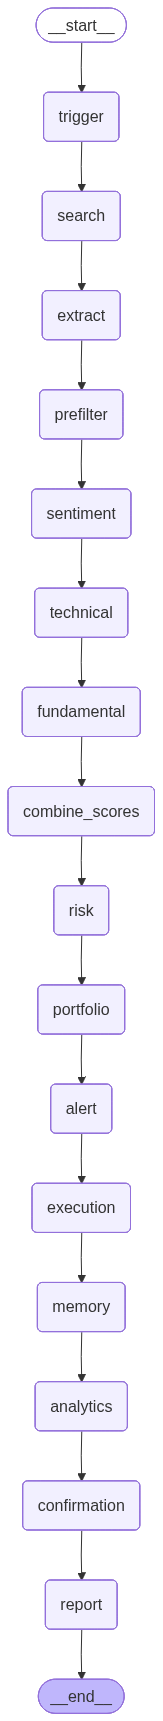

In [36]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
# ── OPTION A: Scheduled (auto-detects market session by time) ──
result = app.invoke({})

# ── OPTION B: Manual query ──
initial_state = manual_trigger("Top AI stocks gaining today")
result = app.invoke(initial_state)

# ── OPTION C: Price alert (scans your watchlist) ──
result = app.invoke({}, config={"configurable": {}})
# (change TRIGGER_MODE = "price_alert" inside trigger_node first)

 Scheduled Trigger fired - session: after-hurs

 Searching: "After hours top gaining stocks US market today"
 -> 7 results found
   → Extracted 20 tickers: ['KIM', 'TRMB', 'CAH', 'HIG', 'AAOI', 'BWIN', 'FIGS', 'DELL', 'HKD', 'AMTD', 'TURB', 'WETH', 'MRM', 'PSKY', 'VEEA', 'BATL', 'CNN', 'NVDA', 'AAPL', 'BAC']

 Pre-Filtering 20 tickers...

  ❌ KIM    REJECTED — not positive today (-0.38%)
  ❌ TRMB   REJECTED — not positive today (-1.99%)
  ✅ CAH    PASSED  — $229.23 (+0.92%) | Vol:2,066,754 | MCap:$53,941,489,664
  ❌ HIG    REJECTED — not positive today (-0.17%)
  ✅ AAOI   PASSED  — $84.23 (+56.88%) | Vol:17,551,056 | MCap:$5,751,215,104
  ✅ BWIN   PASSED  — $23.23 (+25.64%) | Vol:2,610,578 | MCap:$2,760,287,744
  ✅ FIGS   PASSED  — $15.45 (+23.90%) | Vol:25,958,234 | MCap:$2,541,505,024
  ✅ DELL   PASSED  — $148.08 (+21.93%) | Vol:31,164,973 | MCap:$99,243,245,568
  ❌ HKD    REJECTED — not positive today (-0.57%)
  ❌ AMTD   REJECTED — volume too low (16,851)
  ❌ TURB   REJECTED — price

$CNN: possibly delisted; no price data found  (period=5d)


  ❌ CNN    REJECTED — exchange not allowed (YHD) | price too low ($0) | volume too low (0) | market cap too small ($0) | insufficient price history
  ❌ NVDA   REJECTED — not positive today (-4.16%)
  ❌ AAPL   REJECTED — not positive today (-3.21%)
  ❌ BAC    REJECTED — not positive today (-4.72%)

📊 Pre-Filter Summary: 7 passed | 13 rejected

═════════════════════════════════════════════════════════════════
📉 TECHNICAL ANALYSIS AGENT
═════════════════════════════════════════════════════════════════

  📊 Running indicators: CAH
     Score      : 7.0/10
     RSI        : 62.14 | MACD: bullish | OBV: rising
     BB         : above_mid (81.8%) | ATR: 2.28%
     ADX        : 10.973669835044575 | Vol Ratio: 1.2x
     Signals ✅  : ['price > MA20', 'price > MA50', 'RSI healthy (62.14)', 'MACD bullish crossover', 'OBV rising (volume confirming)', 'Price above BB midline', '🚀 Near/At 52-week high breakout!']
     Warnings ⚠️  : ['Stochastic overbought (94.10)', 'ADX weak trend (10.97)', 'Near 20

/tmp/ipykernel_162057/3504050910.py:97: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 6, f"Run ID: {run_id}  |  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  |  Mode: SIMULATED", align="C", ln=True)
/tmp/ipykernel_162057/3504050910.py:39: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 9, f"  {clean_title}", border="L", fill=True, ln=True)
/tmp/ipykernel_162057/3504050910.py:47: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=False use new_x=XPos.RIGHT, new_y=YPos.TOP.
  self.cell(65, 6, f"  {clean_key}", ln=False)
/tmp/ipykernel_162057/3504050910.py:52: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 6, clean_value, ln=True)
/tmp/ipykernel_162057/3504050910.py:233: Depreca

  📄 PDF saved → reports/RUN-1772327000_report.pdf
  📲 WhatsApp sent — SID: SMd573d2191195f83f649dd0c205e136ca
 manual trigger fired - query: 'Top AI stocks gaining today'
 Scheduled Trigger fired - session: after-hurs

 Searching: "After hours top gaining stocks US market today"
 -> 7 results found
   → Extracted 17 tickers: ['HKD', 'AMTD', 'TURB', 'WETH', 'MRM', 'RPGL', 'POWER', 'GROUP', 'AARD', 'KIM', 'TRMB', 'CAH', 'HIG', 'CNN', 'NVDA', 'AAPL', 'BAC']

 Pre-Filtering 17 tickers...

  ❌ HKD    REJECTED — not positive today (-0.57%)
  ❌ AMTD   REJECTED — volume too low (16,851)
  ❌ TURB   REJECTED — price too low ($0.6754) | volume too low (4,456) | market cap too small ($7,440,976)
  ❌ WETH   REJECTED — volume too low (25,657) | market cap too small ($19,567,716) | not positive today (-7.34%)
  ❌ MRM    REJECTED — market cap too small ($10,825,673) | not positive today (-5.26%)
  ❌ RPGL   REJECTED — market cap too small ($6,181,439) | not positive today (-51.34%)


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: POWER"}}}
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: POWER"}}}
$POWER: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: GROUP"}}}


  ❌ POWER  REJECTED — exchange not allowed () | price too low ($0) | volume too low (0) | market cap too small ($0) | insufficient price history | no company info found


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: GROUP"}}}
$GROUP: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


  ❌ GROUP  REJECTED — exchange not allowed () | price too low ($0) | volume too low (0) | market cap too small ($0) | insufficient price history | no company info found
  ❌ AARD   REJECTED — not positive today (-0.08%)
  ❌ KIM    REJECTED — not positive today (-0.38%)
  ❌ TRMB   REJECTED — not positive today (-1.99%)
  ✅ CAH    PASSED  — $229.23 (+0.92%) | Vol:2,066,754 | MCap:$53,941,489,664


$CNN: possibly delisted; no price data found  (period=5d)


  ❌ HIG    REJECTED — not positive today (-0.17%)
  ❌ CNN    REJECTED — exchange not allowed (YHD) | price too low ($0) | volume too low (0) | market cap too small ($0) | insufficient price history
  ❌ NVDA   REJECTED — not positive today (-4.16%)
  ❌ AAPL   REJECTED — not positive today (-3.21%)
  ❌ BAC    REJECTED — not positive today (-4.72%)

📊 Pre-Filter Summary: 1 passed | 16 rejected

═════════════════════════════════════════════════════════════════
📉 TECHNICAL ANALYSIS AGENT
═════════════════════════════════════════════════════════════════

  📊 Running indicators: CAH
     Score      : 7.0/10
     RSI        : 62.14 | MACD: bullish | OBV: rising
     BB         : above_mid (81.8%) | ATR: 2.28%
     ADX        : 10.973669835044575 | Vol Ratio: 1.2x
     Signals ✅  : ['price > MA20', 'price > MA50', 'RSI healthy (62.14)', 'MACD bullish crossover', 'OBV rising (volume confirming)', 'Price above BB midline', '🚀 Near/At 52-week high breakout!']
     Warnings ⚠️  : ['Stochastic overb

/tmp/ipykernel_162057/3504050910.py:97: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 6, f"Run ID: {run_id}  |  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  |  Mode: SIMULATED", align="C", ln=True)
/tmp/ipykernel_162057/3504050910.py:39: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 9, f"  {clean_title}", border="L", fill=True, ln=True)
/tmp/ipykernel_162057/3504050910.py:47: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=False use new_x=XPos.RIGHT, new_y=YPos.TOP.
  self.cell(65, 6, f"  {clean_key}", ln=False)
/tmp/ipykernel_162057/3504050910.py:52: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 6, clean_value, ln=True)
/tmp/ipykernel_162057/3504050910.py:233: Depreca

  📄 PDF saved → reports/RUN-1772327011_report.pdf
  📲 WhatsApp sent — SID: SMfb9ad67b7d1d9e36e6f87d6c74e19c76
 Scheduled Trigger fired - session: after-hurs

 Searching: "After hours top gaining stocks US market today"
 -> 7 results found
   → Extracted 20 tickers: ['KIM', 'TRMB', 'CAH', 'HIG', 'AAOI', 'BWIN', 'FIGS', 'DELL', 'HKD', 'AMTD', 'TURB', 'WETH', 'MRM', 'PSKY', 'VEEA', 'BATL', 'CNN', 'NVDA', 'AAPL', 'BAC']

 Pre-Filtering 20 tickers...

  ❌ KIM    REJECTED — not positive today (-0.38%)
  ❌ TRMB   REJECTED — not positive today (-1.99%)
  ✅ CAH    PASSED  — $229.23 (+0.92%) | Vol:2,066,754 | MCap:$53,941,489,664
  ❌ HIG    REJECTED — not positive today (-0.17%)
  ✅ AAOI   PASSED  — $84.23 (+56.88%) | Vol:17,551,056 | MCap:$5,751,215,104
  ✅ BWIN   PASSED  — $23.23 (+25.64%) | Vol:2,610,578 | MCap:$2,760,287,744
  ✅ FIGS   PASSED  — $15.45 (+23.90%) | Vol:25,958,234 | MCap:$2,541,505,024
  ✅ DELL   PASSED  — $148.08 (+21.93%) | Vol:31,164,973 | MCap:$99,243,245,568
  ❌ HKD    RE

$CNN: possibly delisted; no price data found  (period=5d)


  ✅ BATL   PASSED  — $5.52 (+33.01%) | Vol:54,292,308 | MCap:$90,840,224
  ❌ CNN    REJECTED — exchange not allowed (YHD) | price too low ($0) | volume too low (0) | market cap too small ($0) | insufficient price history
  ❌ NVDA   REJECTED — not positive today (-4.16%)
  ❌ AAPL   REJECTED — not positive today (-3.21%)
  ❌ BAC    REJECTED — not positive today (-4.72%)

📊 Pre-Filter Summary: 7 passed | 13 rejected

═════════════════════════════════════════════════════════════════
📉 TECHNICAL ANALYSIS AGENT
═════════════════════════════════════════════════════════════════

  📊 Running indicators: CAH
     Score      : 7.0/10
     RSI        : 62.14 | MACD: bullish | OBV: rising
     BB         : above_mid (81.8%) | ATR: 2.28%
     ADX        : 10.973669770252618 | Vol Ratio: 1.2x
     Signals ✅  : ['price > MA20', 'price > MA50', 'RSI healthy (62.14)', 'MACD bullish crossover', 'OBV rising (volume confirming)', 'Price above BB midline', '🚀 Near/At 52-week high breakout!']
     Warnings ⚠

/tmp/ipykernel_162057/3504050910.py:97: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 6, f"Run ID: {run_id}  |  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  |  Mode: SIMULATED", align="C", ln=True)
/tmp/ipykernel_162057/3504050910.py:39: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 9, f"  {clean_title}", border="L", fill=True, ln=True)
/tmp/ipykernel_162057/3504050910.py:47: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=False use new_x=XPos.RIGHT, new_y=YPos.TOP.
  self.cell(65, 6, f"  {clean_key}", ln=False)
/tmp/ipykernel_162057/3504050910.py:52: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 6, clean_value, ln=True)
/tmp/ipykernel_162057/3504050910.py:233: Depreca

  📄 PDF saved → reports/RUN-1772327043_report.pdf
  📲 WhatsApp sent — SID: SM743cc80b3d807e4b744e6f2b1887b35c
